In [1]:
import numpy as np
from numpy import linalg as LA
from findiff import *
import matplotlib.pyplot as plt

In [2]:
N = 100
h = 1.0/(N-1)
shape = (N, N)
x, y = np.linspace(0, 1, shape[0]), np.linspace(0, 1, shape[1])
X, Y = np.meshgrid(x, y, indexing='ij')

In [3]:
#exact = X**2 + Y**2 + X**Y
#MA = 3 + np.zeros(shape)

#exact = 0.5*X**4 + X**2 + Y**2
#MA = (6*X**2 + 2)*2

#exact = 0.5*(X-0.5)**4 + X**2 + Y**2
#MA = 12*(X-0.5)**2 + 4

##exact = 0.5*(X-0.5)**4 + Y**2
##MA = 12*(X-0.5)**2

#exact = np.exp(0.5*(X**2 + Y**2)) + 0.3*(X**2 + Y**2)

## This is very strange. If we use numerically computed MA instead of the 
## analytic expressions, ee get convergence within machine epsilon even for a very coarse grid
#exact = np.exp(0.5*(X**2 + Y**2))      
#MA = (1+X**2+Y**2)*np.exp(X**2+Y**2)

## With numerically computed MA this one behaves more like you'd expect. 
## With the analytic expressions, pretty much same as the example above

exact = np.exp(0.25*((X-Y)**2 + (X+Y)**2))
MA = (1+X**2+Y**2)*np.exp(X**2+Y**2)

#exact = np.exp(0.5*(X**4 + Y**2))      ## Degenerate for x=0
#MA = 2*X**2*(2*X**4+3*Y**2+3)*np.exp(X**4+Y**2)

#exact = -np.sqrt(2 - X**2 - Y**2)
#MA = np.minimum(2.0/(2-X**2-Y**2)**2, 1e6)

#exact = 0.5*np.maximum(0, np.sqrt((X-0.5)**2 + (Y-0.5)**2) - 0.2)**2
#MA =np.maximum(0,1-0.2/(np.sqrt((X-0.5)**2 + (Y-0.5)**2) - 0.2))

##exact = 0.2*(X**2 + Y**2) + np.maximum(X**4+Y**2,Y**4+X**2)

#exact = np.maximum(X,Y)   ## Works much better than expected
#exact = np.maximum(X**2, Y**2) ## Works much worse than I expected

#exact = 0.2*(X**2 + Y**2) + np.maximum(X, Y)   ## Terrible. The computed Hessian has non-positive determinant almost everywhere
#MA = 0.8 + np.zeros(shape)
##
## Evil example. There is no convex function whose Laplace is 2sqrt(MA)

##exact = 1.0 + np.zeros(shape)
##MA = (X**2 + Y**2)**(3/2) * (np.sqrt(X**2 + Y**2) - 2)**2

#a = 0.9
#R2 = X**2 + Y**2
#R = np.sqrt(R2)
#MA=(16.2 - 16*R2)**2 / 4
#b=2.031
#c=1.52
#d=0.88
#exact=0.5*b*((R**2 -c)*np.sqrt((R**2-c)**2 +d**2)+d**2 *np.log((R**2 -c)+np.sqrt((R**2 -c)**2 +d**2)))
#exact = np.sqrt(450*a**4*R2  - 360*a**2*R2**2 + 96*R2**3) / (768 * R * np.sqrt(450*a**4 - 360*R2*a**2 + 96*R2**2)) * (75 * a**4 * np.log(np.sqrt(96)*R2 - 15*np.sqrt(96)*a**2/8 + np.sqrt(450*a**4 - 360*R2*a**2 + 96*R2**2)) * np.sqrt(96) + (64*R2 - 120)*np.sqrt(450*a**4 - 360*R2*a**2 + 96*R2**2))

##print(exact)
##print(d2_dx2(exact)*d2_dy2(exact) - d2_dxdy(exact)*d2_dydx(exact))

In [4]:
##print(exact)
##print(d2_dx2(exact)*d2_dy2(exact) - d2_dxdy(exact)*d2_dydx(exact))

In [5]:
d_dx = FinDiff(0, h, 1)
d_dy = FinDiff(1, h, 1)

a = 2

d2_dx2 = FinDiff(0, h, 2, acc=a)
d2_dy2 = FinDiff(1, h, 2, acc=a)
d2_dxdy = FinDiff((0, h, 1), (1, h, 1), acc=a)
d2_dydx = FinDiff((1, h, 1), (0, h, 1), acc=a)

d2_dx2_4 = FinDiff(0, h, 2, acc=4)
d2_dy2_4 = FinDiff(1, h, 2, acc=4)
d2_dxdy_4 = FinDiff((0, h, 1), (1, h, 1), acc=4)
d2_dydx_4 = FinDiff((1, h, 1), (0, h, 1), acc=4)

In [6]:
## If the exact MA is not available, we can try to compute a numerical approximation
## but, this seems to give "too good" solutions, so it's probably better to avoid this

f = 2.0 * np.sqrt(np.maximum(0, d2_dx2(exact)*d2_dy2(exact) - d2_dxdy(exact)*d2_dydx(exact)))

## Use the exact MA if available
#f = 2.0*np.sqrt(MA)

In [7]:
bc = BoundaryConditions(shape)
bc[1,:] = exact
bc[-1,:] = exact
bc[:, 1] = exact
bc[:, -1] = exact

In [8]:
singularity = np.zeros(shape)

In [9]:
def Bellman(u00, u01, u11):

    B = np.array([[u00, u01], [u01, u11]])
    
    eigenvalues, eigenvectors = LA.eigh(B)
    T = eigenvectors
    
    D = LA.det(B)

    if max(eigenvalues)< 0:
        eigenvalues=-eigenvalues
    elif eigenvalues[0]==0 and eigenvalues[1]==0:
        return "zeros"
    elif D==0 and min(eigenvalues)==0:
        return np.identity(2), max(eigenvalues)
    elif D==0 and max(eigenvalues)==0:
        return np.identity(2),min(eigenvalues)
    elif D < 0:
        return np.identity(2), D
        
    Ap = np.sqrt(D) * np.diag(1/eigenvalues)
    A = T @ Ap @ T.transpose()


    return A, 0

In [10]:
def search_points_c1(k,j):
    for m in range(0,j+1):
        #print("s",singularity[k][m])
        if singularity[k][j-m]==0:
            return j-m
    return j
def search_points_c2(k,j):
    for m in range(j+1,N):
        #print("s",singularity[k][m])
        if singularity[k][m]==0:
            return m
    return j
def search_points_r1(k,j):
    for m in range(0,k+1):
        #print("s",singularity[k][m])
        if singularity[k-m][j]==0:
            return k-m
    return k
def search_points_r2(k,j):
    for m in range(k+1,N):
        #print("s",singularity[k][m])
        if singularity[m][j]==0:
            return m
    return k

In [11]:
def additional_search_1(k,j):
    for m in range(1,k):
        c1=search_points_c1(k-m,j)
        c2=search_points_c2(k-m,j)
        if c1!=j and c2!=j:
            return k-m,c1,k-m,c2
        elif c1!=j and c2==j:
            return k-m,c1,k,c2
        elif c1==j and c2!=j:
            return k,c1,k-m,c2
    return k,j,k,j
def additional_search_2(k,j):
    for m in range(k+1,N):
        c1=search_points_c1(m,j)
        c2=search_points_c2(m,j)
        if c1!=j and c2!=j:
            return m,c1,m,c2
        elif c1!=j and c2==j:
            return m,c1,k,c2
        elif c1==j and c2!=j:
            return k,c1,m,c2
    return k,j,k,j

In [12]:
def interpolation(k,j,r1,r2,c1,c2):
    d_r=r2-r1
    d_c=c2-c1
    if d_r+d_c==0:
        r11=additional_search_1(k,j)[0]
        r12=additional_search_1(k,j)[2]
        r21=additional_search_2(k,j)[0]
        r22=additional_search_2(k,j)[2]
        c11=additional_search_1(k,j)[1]
        c12=additional_search_1(k,j)[3]
        c21=additional_search_2(k,j)[1]
        c22=additional_search_2(k,j)[3]
        #print("k",k,"j",j,"r11",r11,"r12",r12,"r21",r21,"r22",r22,"c11",c11,"c12",c12,"c21",c21,"c22",c22)
        d11=np.sqrt((k-r11)**2 + (j-c11)**2)
        d12=np.sqrt((k-r12)**2 + (j-c12)**2)
        d21=np.sqrt((k-r21)**2 + (j-c21)**2)
        d22=np.sqrt((k-r22)**2 + (j-c22)**2)
        d=d11+d12+d21+d22
        A_11=np.array([[B00[r11][c11],B01[r1][c11]],[B01[r11][c11],B11[r11][c11]]])
        A_12=np.array([[B00[r12][c12],B01[r12][c12]],[B01[r12][c12],B11[r12][c12]]])
        A_21=np.array([[B00[r12][c21],B01[r12][c21]],[B01[r12][c21],B11[r12][c21]]])
        A_22=np.array([[B00[r22][c22],B01[r22][c22]],[B01[r22][c22],B11[r22][c22]]])
        A=(1/d)*(d11*A_11+d12*A_12+d21*A_21+d22*A_22)
        det_A=LA.det(A)
        C=A/np.sqrt(det_A)
        return C
    A_r1=np.array([[B00[r1][j],B01[r1][j]],[B01[r1][j],B11[r1][j]]])
    A_r2=np.array([[B00[r2][j],B01[r2][j]],[B01[r2][j],B11[r2][j]]])
    A_c1=np.array([[B00[k][c1],B01[k][c1]],[B01[k][c1],B11[k][c1]]])
    A_c2=np.array([[B00[k][c2],B01[k][c2]],[B01[k][c2],B11[k][c2]]])
    A=(1/(d_r+d_c))*((k-r1)*A_r1+(r2-k)*A_r2+(j-c1)*A_c1+(c2-j)*A_c2)
    det_A=LA.det(A)
    #if det_A==0:
        #print("A",A,"A_r1",A_r1,"A_r2",A_r2,"A_c1",A_c1,"A_c2",A_c2,"dr+dc",d_r+d_c)
        #print("1",(1/(d_r+d_c))*(k-r1)*A_r1,"2",(1/(d_r+d_c))*(r2-k)*A_r2,"3",(1/(d_r+d_c))*(j-c1)*A_c1,"4",(1/(d_r+d_c))*(c2-j)*A_c2)
    C=A/np.sqrt(det_A)
    return C

    

In [13]:
def eigen_interpolation(k,j,r1,r2,c1,c2):
    d_r=r2-r1
    d_c=c2-c1
    if d_r+d_c==0:
        r11=additional_search_1(k,j)[0]
        r12=additional_search_1(k,j)[2]
        r21=additional_search_2(k,j)[0]
        r22=additional_search_2(k,j)[2]
        c11=additional_search_1(k,j)[1]
        c12=additional_search_1(k,j)[3]
        c21=additional_search_2(k,j)[1]
        c22=additional_search_2(k,j)[3]
        #print("k",k,"j",j,"r11",r11,"r12",r12,"r21",r21,"r22",r22,"c11",c11,"c12",c12,"c21",c21,"c22",c22)
        d11=np.sqrt((k-r11)**2 + (j-c11)**2)
        d12=np.sqrt((k-r12)**2 + (j-c12)**2)
        d21=np.sqrt((k-r21)**2 + (j-c21)**2)
        d22=np.sqrt((k-r22)**2 + (j-c22)**2)
        d=d11+d12+d21+d22
        A_11=np.array([[B00[r11][c11],B01[r11][c11]],[B01[r11][c11],B11[r11][c11]]])
        e_11,vec_11=LA.eigh(A_11)
        A_12=np.array([[B00[r12][c12],B01[r12][c12]],[B01[r12][c12],B11[r12][c12]]])
        e_12,vec_12=LA.eigh(A_12)
        A_21=np.array([[B00[r21][c21],B01[r21][c21]],[B01[r21][c21],B11[r21][c21]]])
        e_21,vec_21=LA.eigh(A_21)
        A_22=np.array([[B00[r22][c22],B01[r22][c22]],[B01[r22][c22],B11[r22][c22]]])
        e_22,vec_22=LA.eigh(A_22)
        e=(1/d)*(d11*e_11 +d12*e_12 +d21*e_21+d22*e_22)
        vec=(1/d)*(d11*vec_11 +d12*vec_12 +d21*vec_21+d22*vec_22)
        #if e[0]*e[1]<=0:
            #print("k",k,"j",j,"s",singularity[k][j],"c1",c1,"c2",c2,"r1",r1,"r2",r2,"e_r1",e_r1,"e_r2",e_r2,"e_c1",e_c1,"e_c2",e_c2)
        det_sq=np.sqrt(e[0]*e[1])
        M=np.matmul(vec,np.matmul(np.diag(e),np.transpose(vec)))/det_sq
        return M
    A_r1=np.array([[B00[r1][j],B01[r1][j]],[B01[r1][j],B11[r1][j]]])
    e_r1,vec_r1=LA.eigh(A_r1)
    A_r2=np.array([[B00[r2][j],B01[r2][j]],[B01[r2][j],B11[r2][j]]])
    e_r2,vec_r2=LA.eigh(A_r2)
    A_c1=np.array([[B00[k][c1],B01[k][c1]],[B01[k][c1],B11[k][c1]]])
    e_c1,vec_c1=LA.eigh(A_c1)
    A_c2=np.array([[B00[k][c2],B01[k][c2]],[B01[k][c2],B11[k][c2]]])
    e_c2,vec_c2=LA.eigh(A_c2)
    #if min(e_r1)< 0:
        #print("error! A_r1 not positive definite!")
    #if min(e_r2)< 0:
        #print("error! A_r2 not positive definite!")
    #if min(e_c1)< 0:
        #print("error! A_r1 not positive definite!")
    #if min(e_c2)< 0:
        #print("error! A_r1 not positive definite!")
    e=(1/(d_r+d_c))*((k-r1)*e_r1 +(r2-k)*e_r2+(j-c1)*e_c1+(c2-j)*e_c2)
    vec=(1/(d_r+d_c))*((k-r1)*vec_r1 +(r2-k)*vec_r2+(j-c1)*vec_c1+(c2-j)*vec_c2)
    #if e[0]*e[1]<0:
        #print("k",k,"j",j,"s",singularity[k][j],"c1",c1,"c2",c2,"r1",r1,"r2",r2,"e_r1",e_r1,"e_r2",e_r2,"e_c1",e_c1,"e_c2",e_c2)
    det_sq=np.sqrt(e[0]*e[1])
    M=np.matmul(vec,np.matmul(np.diag(e),np.transpose(vec)))/det_sq
    return M

In [14]:
def eigen_interpolation_2(k,j,r1,r2,c1,c2):
    d_r=r2-r1
    d_c=c2-c1
    if d_r+d_c==0:
        r11=additional_search_1(k,j)[0]
        r12=additional_search_1(k,j)[2]
        r21=additional_search_2(k,j)[0]
        r22=additional_search_2(k,j)[2]
        c11=additional_search_1(k,j)[1]
        c12=additional_search_1(k,j)[3]
        c21=additional_search_2(k,j)[1]
        c22=additional_search_2(k,j)[3]
        #print("k",k,"j",j,"r11",r11,"r12",r12,"r21",r21,"r22",r22,"c11",c11,"c12",c12,"c21",c21,"c22",c22)
        d11=np.sqrt((k-r11)**2 + (j-c11)**2)
        d12=np.sqrt((k-r12)**2 + (j-c12)**2)
        d21=np.sqrt((k-r21)**2 + (j-c21)**2)
        d22=np.sqrt((k-r22)**2 + (j-c22)**2)
        d=d11+d12+d21+d22
        A_11=np.array([[u00[r11][c11],u01[r11][c11]],[u01[r11][c11],u11[r11][c11]]])
        e_11,vec_11=LA.eigh(A_11)
        if max(e_11)< 0:
            e_11=-e_11
        A_12=np.array([[u00[r12][c12],u01[r12][c12]],[u01[r12][c12],u11[r12][c12]]])
        e_12,vec_12=LA.eigh(A_12)
        if max(e_12)< 0:
            e_12=-e_12
        A_21=np.array([[u00[r21][c21],u01[r21][c21]],[u01[r21][c21],u11[r21][c21]]])
        e_21,vec_21=LA.eigh(A_21)
        if max(e_21)< 0:
            e_21=-e_21
        A_22=np.array([[u00[r22][c22],u01[r22][c22]],[u01[r22][c22],u11[r22][c22]]])
        e_22,vec_22=LA.eigh(A_22)
        if max(e_22)< 0:
            e_22=-e_2
        e=(1/d)*(d11*e_11 +d12*e_12 +d21*e_21+d22*e_22)
        vec=(1/d)*(d11*vec_11 +d12*vec_12 +d21*vec_21+d22*vec_22)
        #if e[0]*e[1]<=0:
            #print("additional","e[0]*e[1]",e[0]*e[1])
            #print("additional","k",k,"j",j,"s",singularity[k][j],"r1",r1,"r2",r2,"c11",c11,"c12",c12,"c21",c21,"c22",c22)
            #print("additional","d11*e_11",d11*e_11,"d12*e_12",d12*e_12,"d21*e_21",d21*e_21,"d22*e_21",d22*e_22)
        det_sq=np.sqrt(e[0]*e[1])
        M=np.matmul(vec,np.matmul(np.diag(e),np.transpose(vec)))/det_sq
        return M
    A_r1=np.array([[u00[r1][j],u01[r1][j]],[u01[r1][j],u11[r1][j]]])
    e_r1,vec_r1=LA.eigh(A_r1)
    if max(e_r1)< 0:
        e_r1=-e_r1
        #print("error! A_r1 not positive definite!",  LA.det(A_r1))
    A_r2=np.array([[u00[r2][j],u01[r2][j]],[u01[r2][j],u11[r2][j]]])
    e_r2,vec_r2=LA.eigh(A_r2)
    if max(e_r2)< 0:
        e_r2=-e_r2
        #print("error! A_r2 not positive definite!", LA.det(A_r2))
    A_c1=np.array([[u00[k][c1],u01[k][c1]],[u01[k][c1],u11[k][c1]]])
    e_c1,vec_c1=LA.eigh(A_c1)
    if max(e_c1)< 0:
        e_c1=-e_c1
        #print("error! A_c1 not positive definite!",  LA.det(A_c1))
    A_c2=np.array([[u00[k][c2],u01[k][c2]],[u01[k][c2],u11[k][c2]]])
    e_c2,vec_c2=LA.eigh(A_c2)
    if max(e_c2)< 0:
        e_c2=-e_c2
        #print("error! A_c2 not positive definite!",  LA.det(A_c2))
    e=(1/(d_r+d_c))*((k-r1)*e_r1 +(r2-k)*e_r2+(j-c1)*e_c1+(c2-j)*e_c2)
    vec=(1/(d_r+d_c))*((k-r1)*vec_r1 +(r2-k)*vec_r2+(j-c1)*vec_c1+(c2-j)*vec_c2)
    #if min(e_r1)<0 or min(e_r2)<0 or min(e_c1)<0 or min(e_c2)<0:
        #print("k",k,"j",j,"s",singularity[k][j],"c1",c1,"c2",c2,"r1",r1,"r2",r2,"e_r1",e_r1,"e_r2",e_r2,"e_c1",e_c1,"e_c2",e_c2)
    #if e[0]*e[1]<0:
        #print("e[0]*e[1]",e[0]*e[1])
        #print("k",k,"j",j,"e",e)
        #print("(k-r1)*e_r1",(k-r1)*e_r1,"(r2-k)*e_r2",(r2-k)*e_r2,"(j-c1)*e_c1",(j-c1)*e_c1,"(c2-j)*e_c2",(c2-j)*e_c2)
    det_u_sq=np.sqrt(e[0]*e[1])
    M=det_u_sq*np.matmul(vec,np.matmul(np.diag(1/e),np.transpose(vec)))
    return M

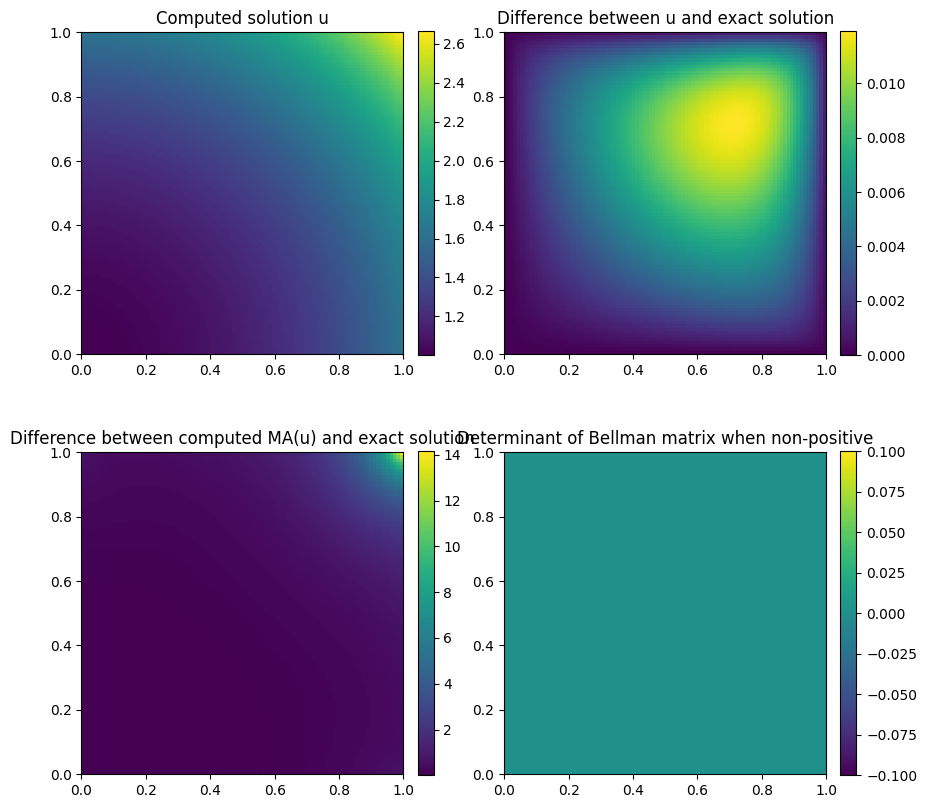

N =  100
Computed solution : Maximal error =  1.19e-02 Average l^2 error =  5.91e-05
Computed MA       : Maximal error =  1.42e+01 Average l^2 error =  1.05e-02  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


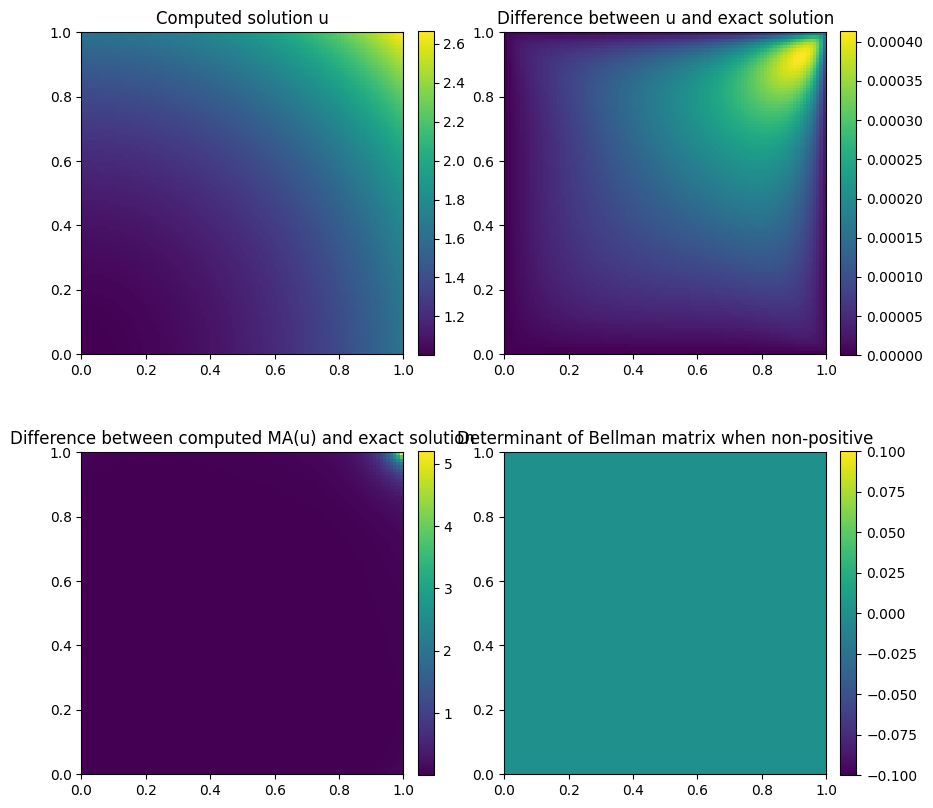

N =  100
Computed solution : Maximal error =  4.13e-04 Average l^2 error =  1.37e-06
Computed MA       : Maximal error =  5.20e+00 Average l^2 error =  1.46e-03  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


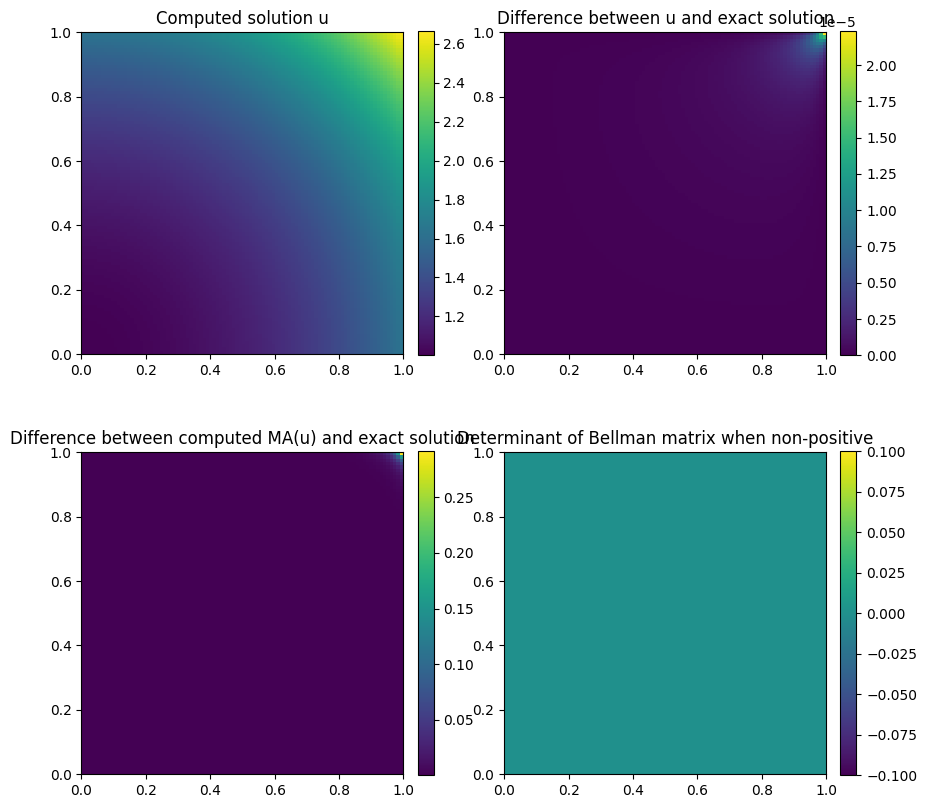

N =  100
Computed solution : Maximal error =  2.23e-05 Average l^2 error =  8.00e-09
Computed MA       : Maximal error =  2.91e-01 Average l^2 error =  4.45e-05  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


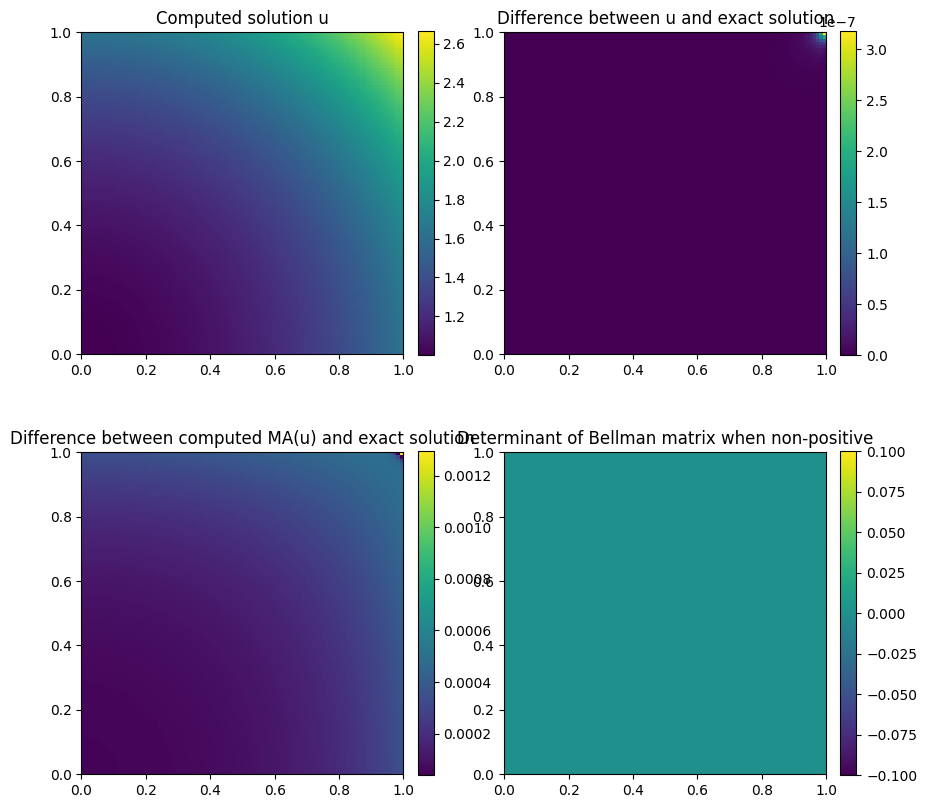

N =  100
Computed solution : Maximal error =  3.18e-07 Average l^2 error =  5.31e-11
Computed MA       : Maximal error =  1.29e-03 Average l^2 error =  2.32e-06  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


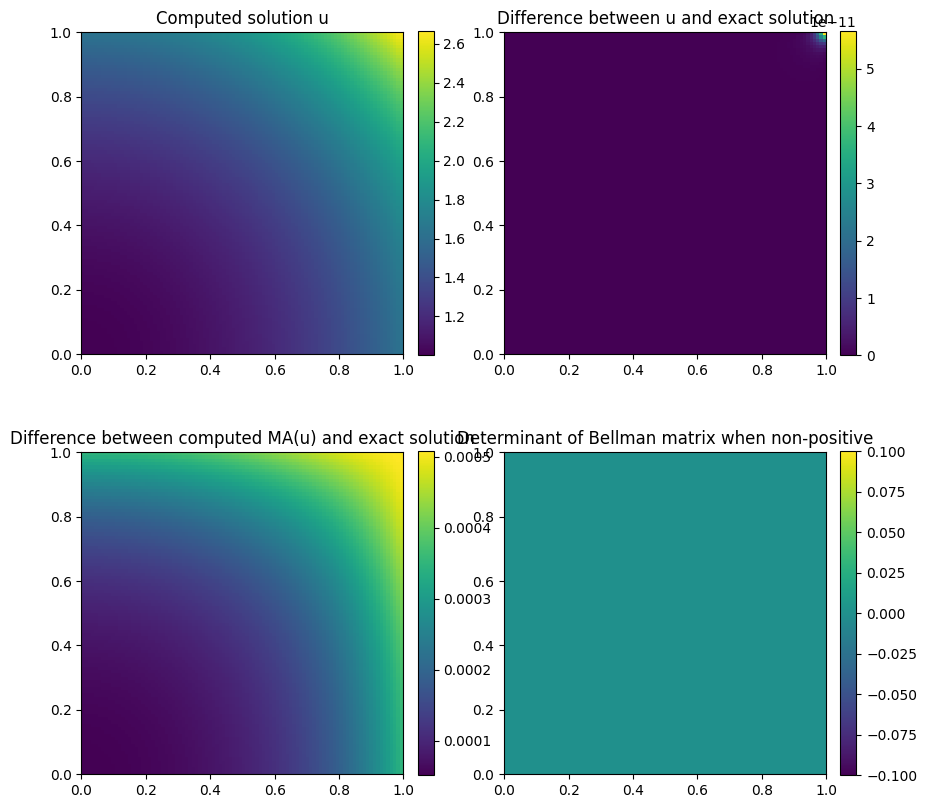

N =  100
Computed solution : Maximal error =  5.66e-11 Average l^2 error =  9.66e-15
Computed MA       : Maximal error =  5.08e-04 Average l^2 error =  2.32e-06  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


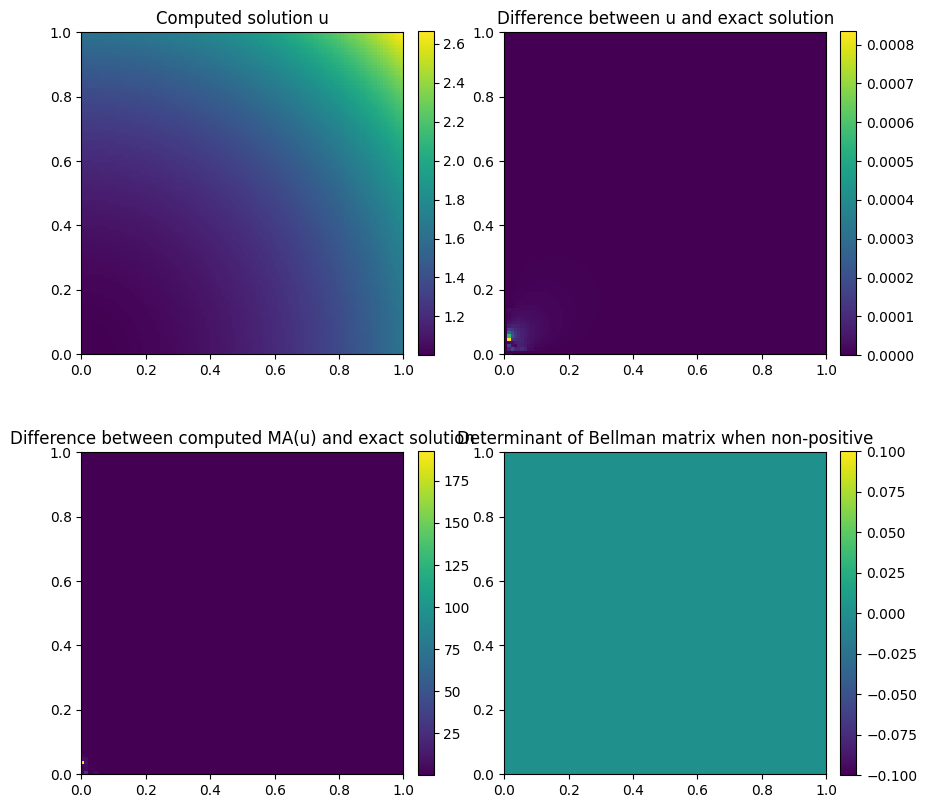

N =  100
Computed solution : Maximal error =  8.34e-04 Average l^2 error =  1.34e-07
Computed MA       : Maximal error =  1.93e+02 Average l^2 error =  2.03e-02  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


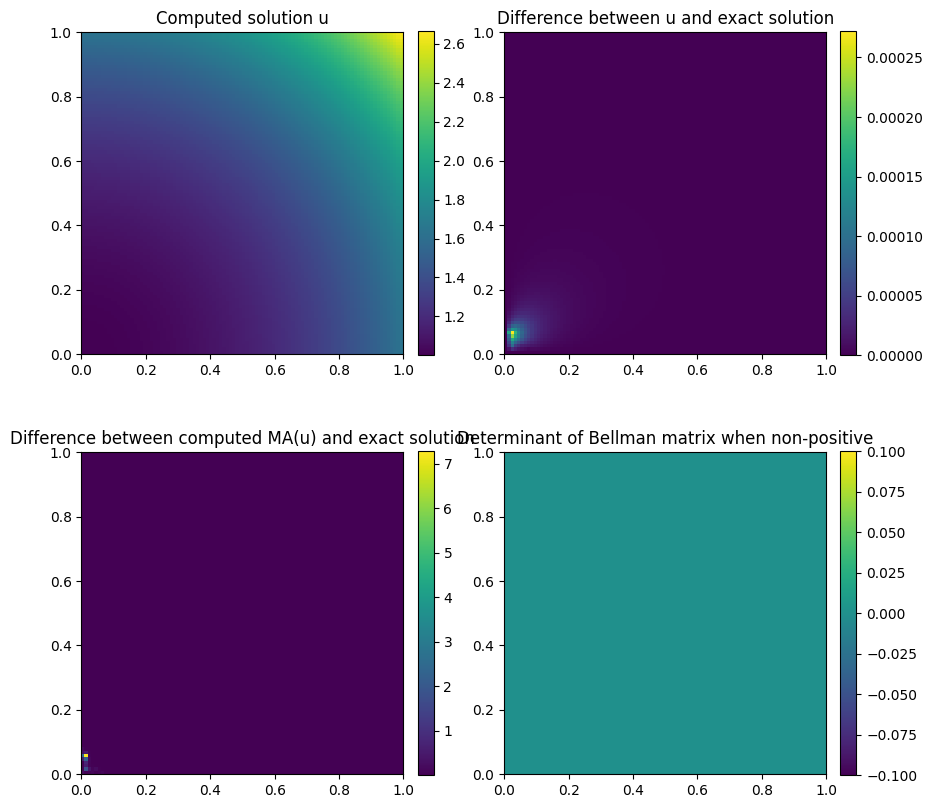

N =  100
Computed solution : Maximal error =  2.72e-04 Average l^2 error =  8.33e-08
Computed MA       : Maximal error =  7.28e+00 Average l^2 error =  8.67e-04  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


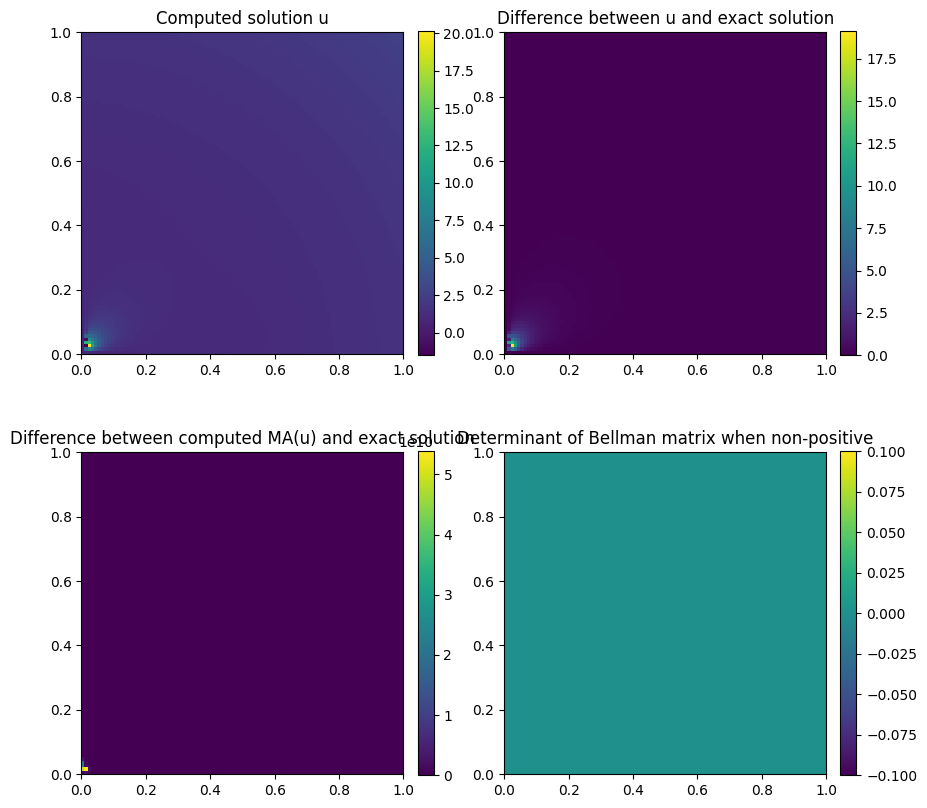

N =  100
Computed solution : Maximal error =  1.91e+01 Average l^2 error =  4.13e-03
Computed MA       : Maximal error =  5.38e+10 Average l^2 error =  8.29e+06  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


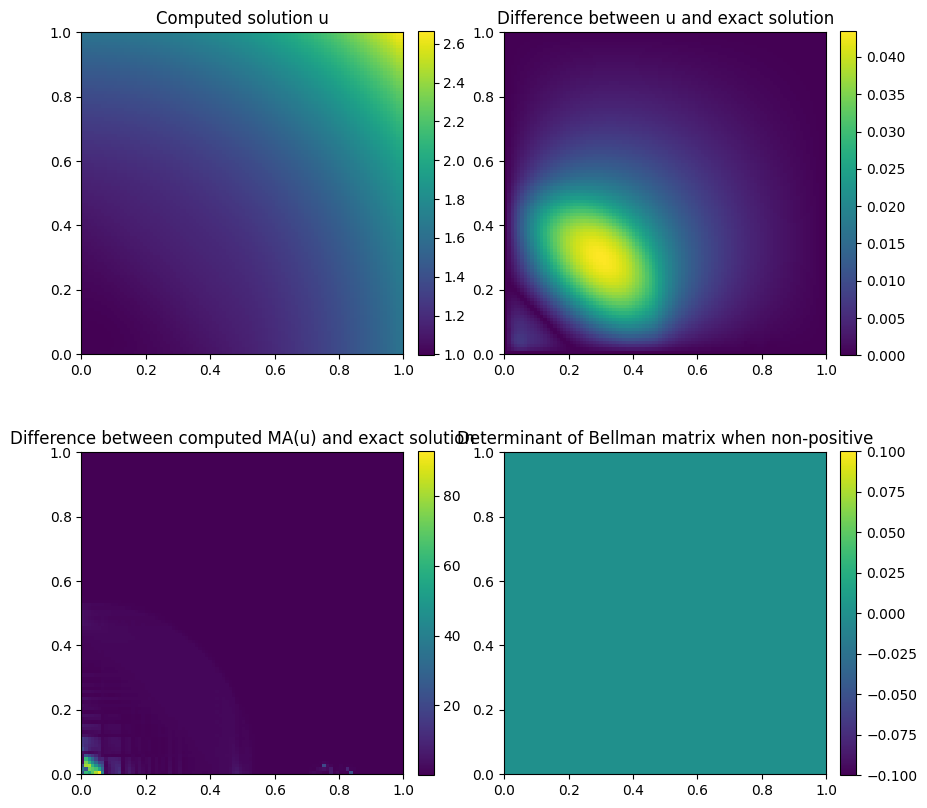

N =  100
Computed solution : Maximal error =  4.34e-02 Average l^2 error =  1.34e-04
Computed MA       : Maximal error =  9.27e+01 Average l^2 error =  3.34e-02  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


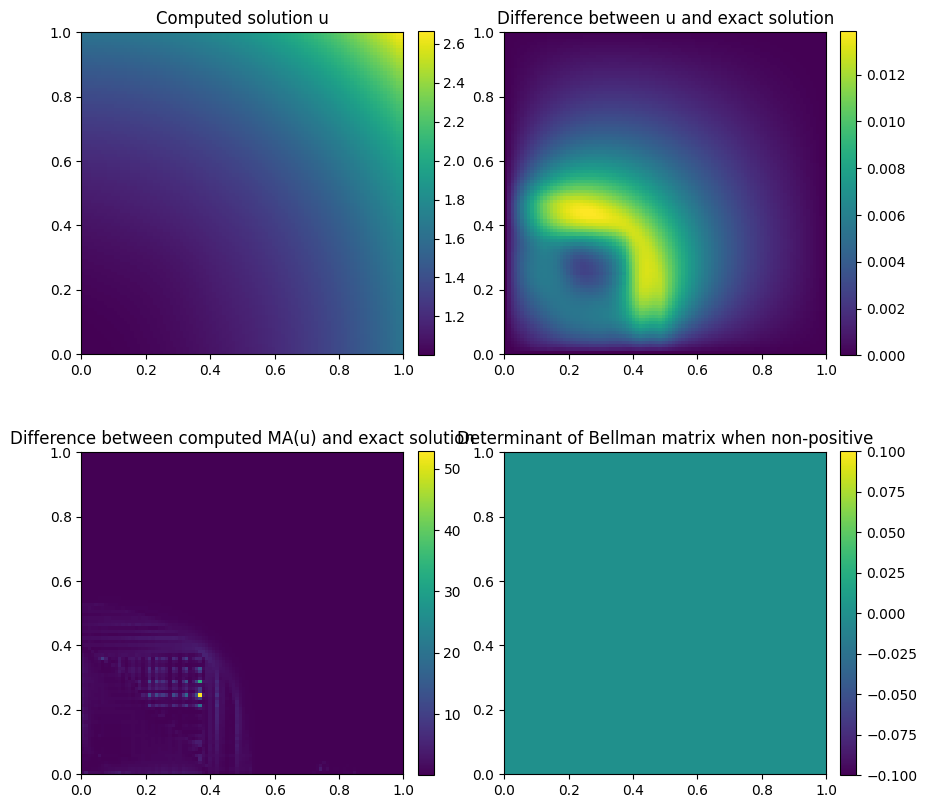

N =  100
Computed solution : Maximal error =  1.39e-02 Average l^2 error =  4.96e-05
Computed MA       : Maximal error =  5.29e+01 Average l^2 error =  1.22e-02  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


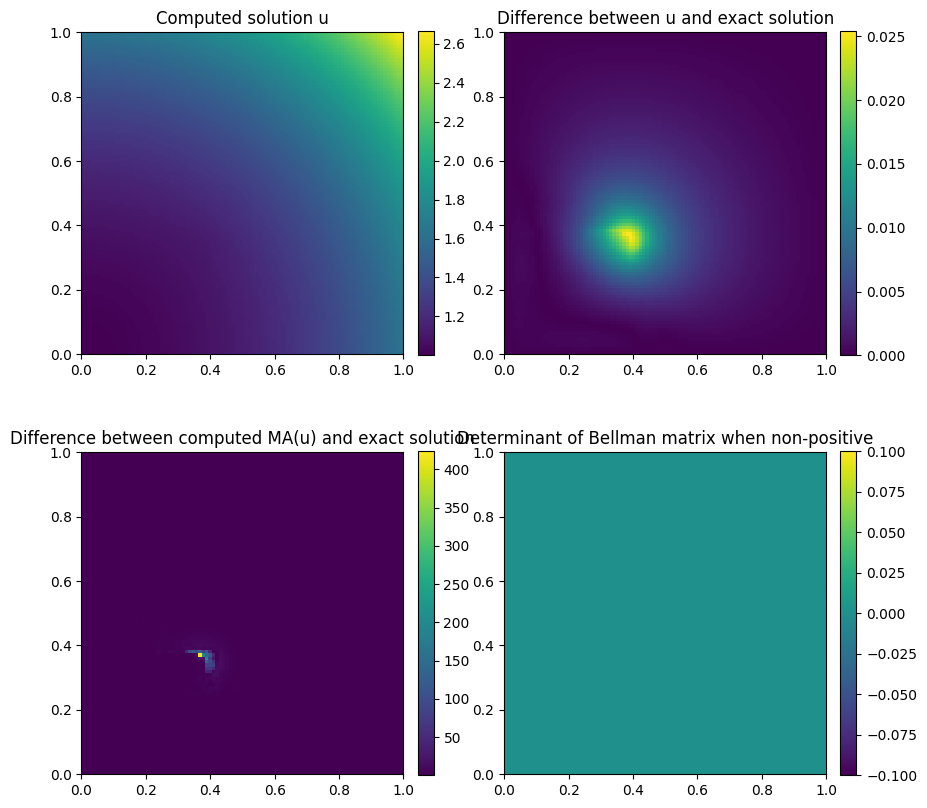

N =  100
Computed solution : Maximal error =  2.54e-02 Average l^2 error =  3.85e-05
Computed MA       : Maximal error =  4.24e+02 Average l^2 error =  6.94e-02  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


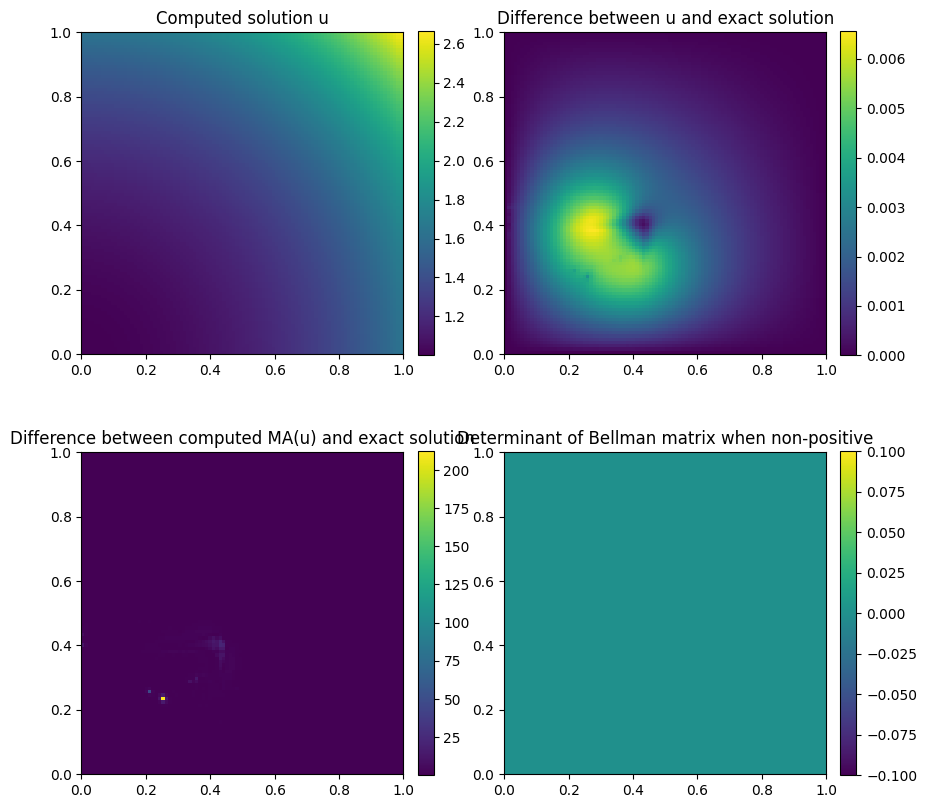

N =  100
Computed solution : Maximal error =  6.56e-03 Average l^2 error =  1.99e-05
Computed MA       : Maximal error =  2.12e+02 Average l^2 error =  2.41e-02  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


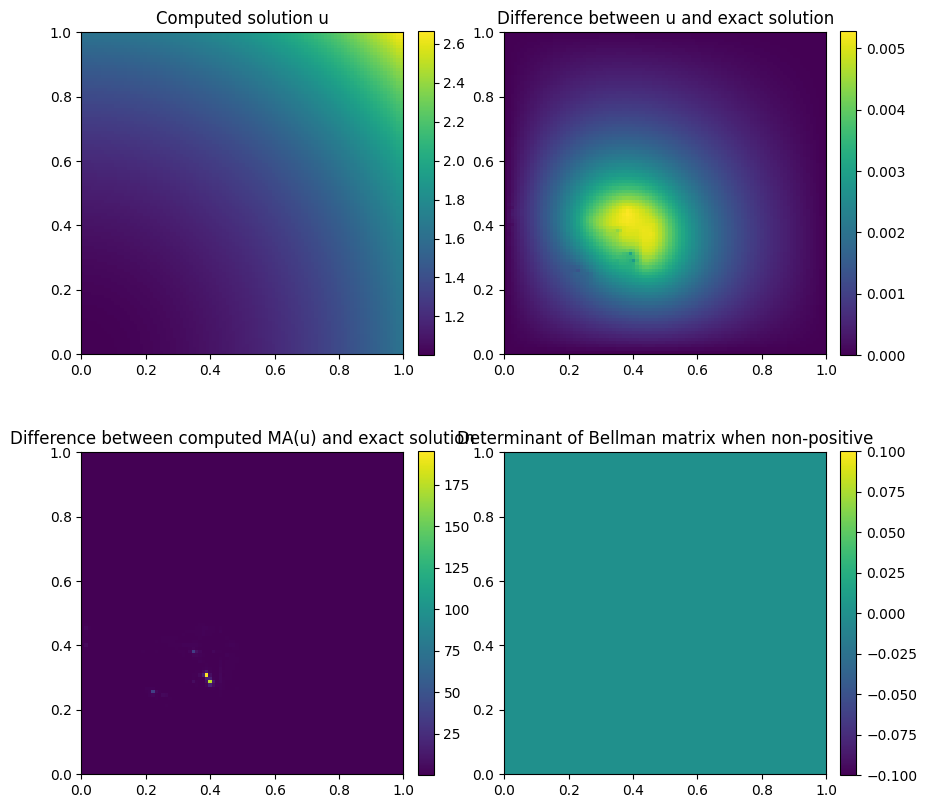

N =  100
Computed solution : Maximal error =  5.28e-03 Average l^2 error =  1.57e-05
Computed MA       : Maximal error =  1.95e+02 Average l^2 error =  2.83e-02  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


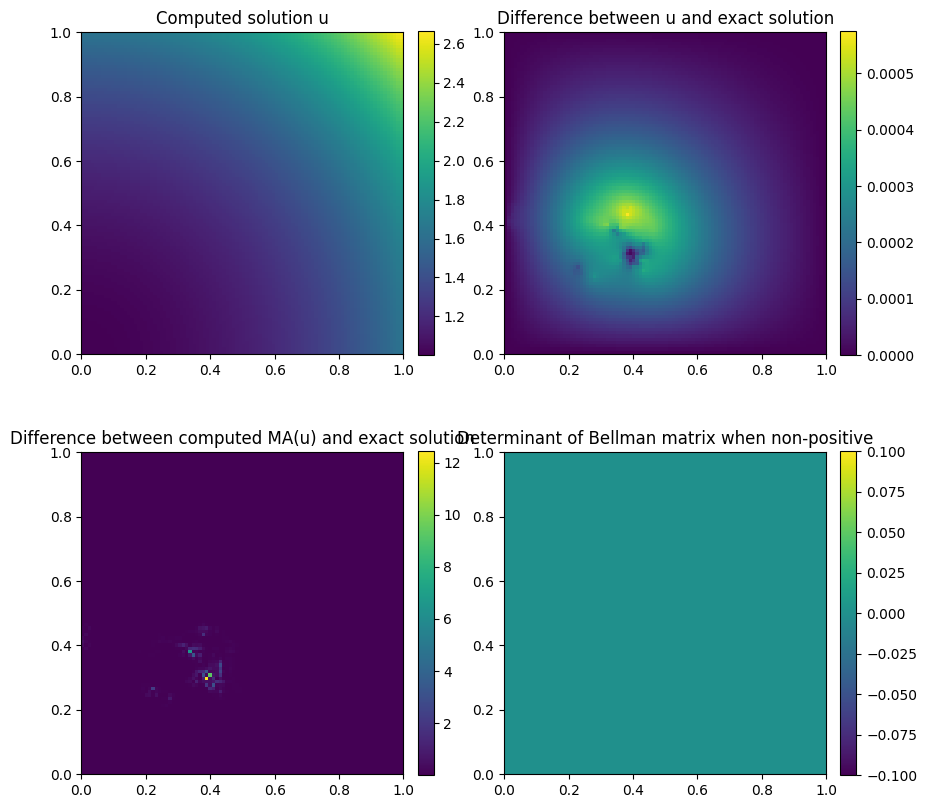

N =  100
Computed solution : Maximal error =  5.74e-04 Average l^2 error =  1.56e-06
Computed MA       : Maximal error =  1.24e+01 Average l^2 error =  2.09e-03  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


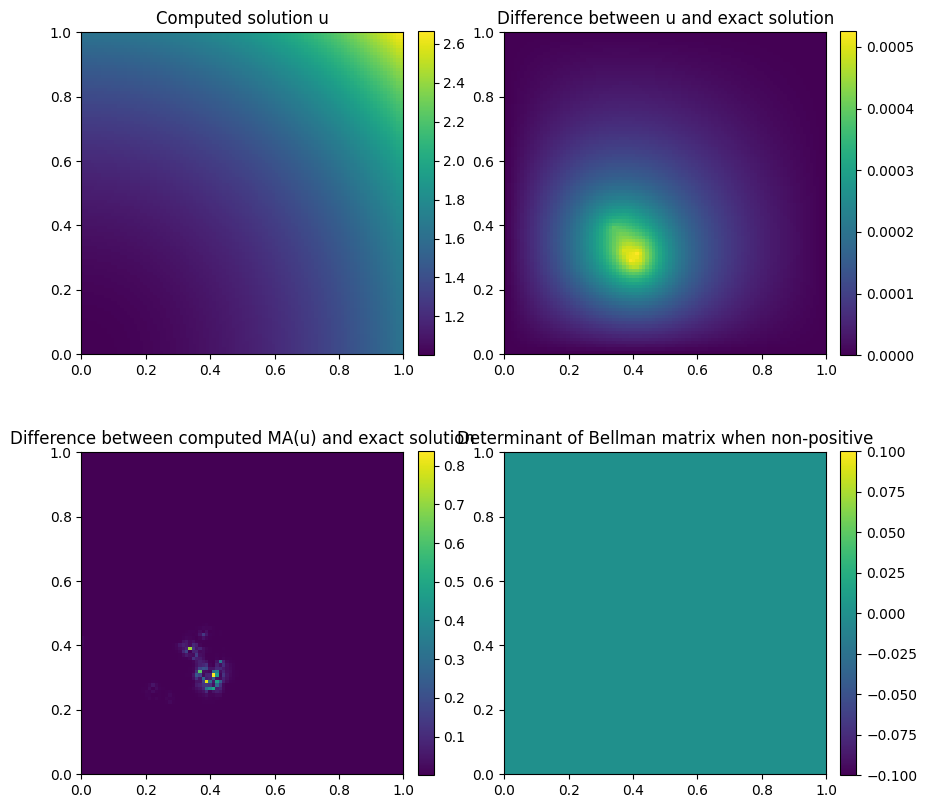

N =  100
Computed solution : Maximal error =  5.25e-04 Average l^2 error =  1.15e-06
Computed MA       : Maximal error =  8.37e-01 Average l^2 error =  2.23e-04  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


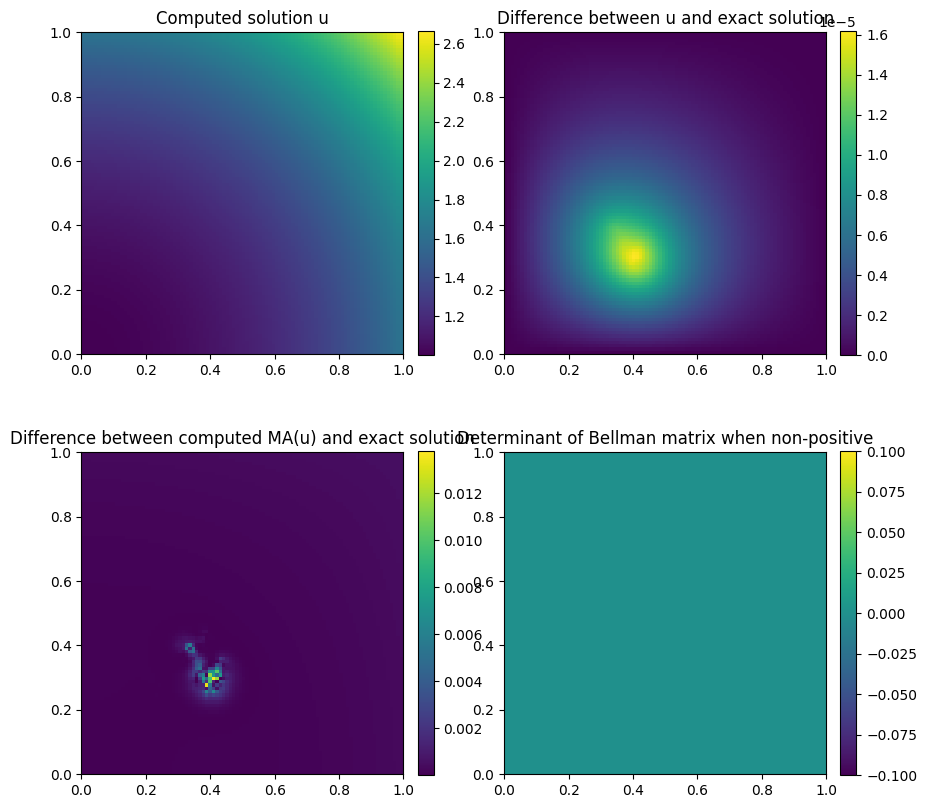

N =  100
Computed solution : Maximal error =  1.62e-05 Average l^2 error =  3.88e-08
Computed MA       : Maximal error =  1.38e-02 Average l^2 error =  5.32e-06  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


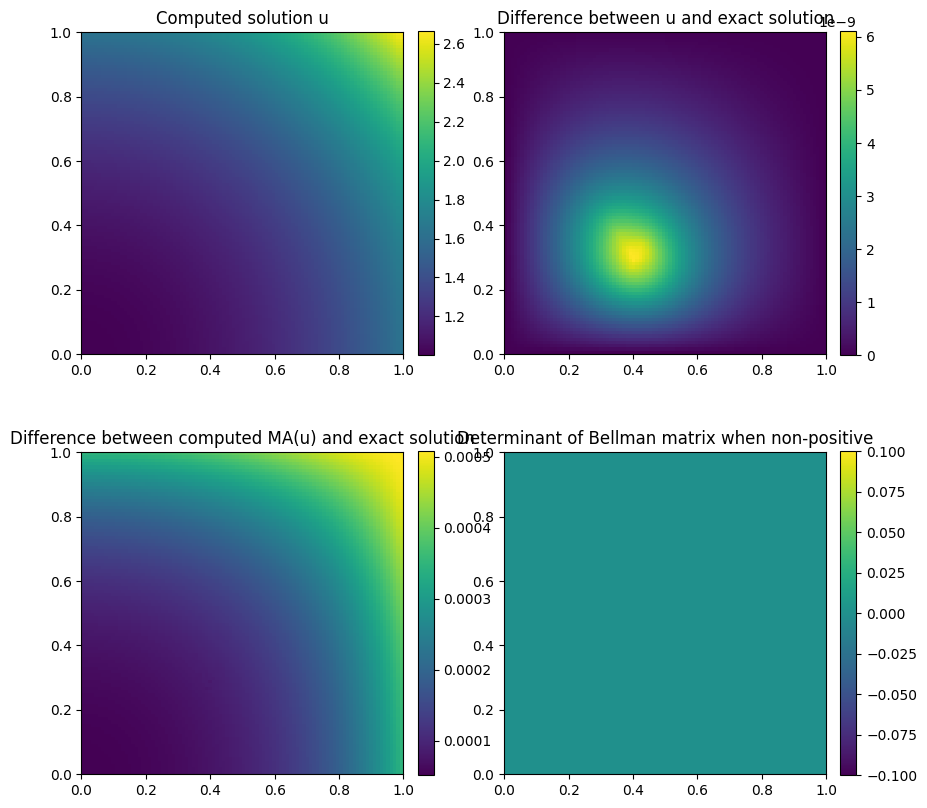

N =  100
Computed solution : Maximal error =  6.11e-09 Average l^2 error =  1.69e-11
Computed MA       : Maximal error =  5.08e-04 Average l^2 error =  2.32e-06  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


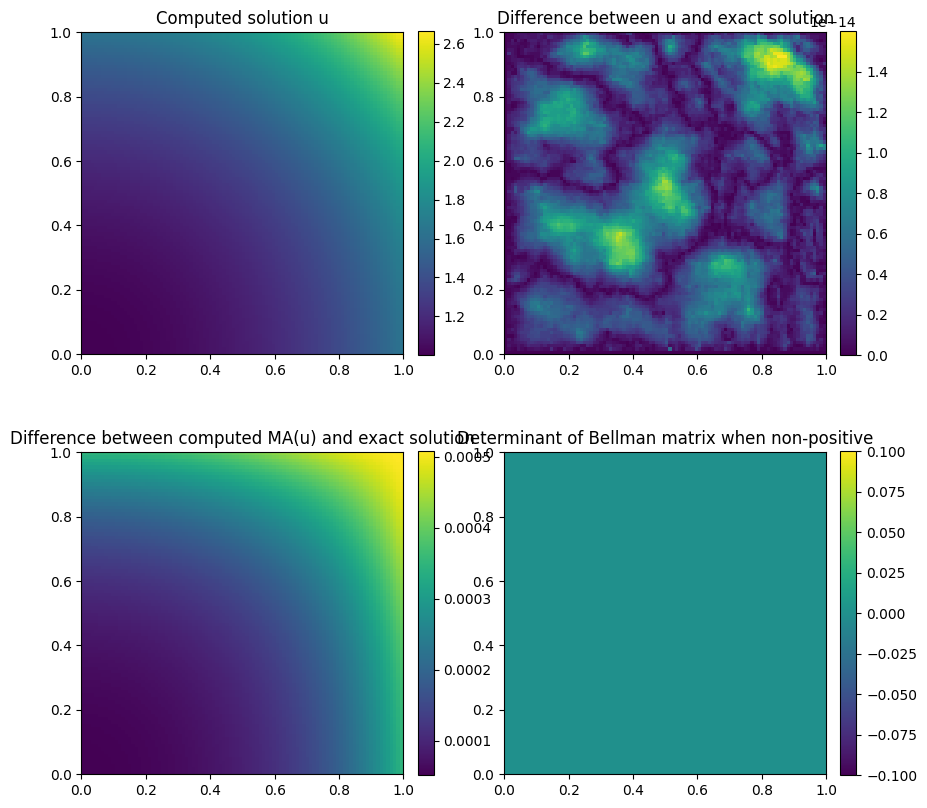

N =  100
Computed solution : Maximal error =  1.60e-14 Average l^2 error =  4.96e-17
Computed MA       : Maximal error =  5.08e-04 Average l^2 error =  2.32e-06  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


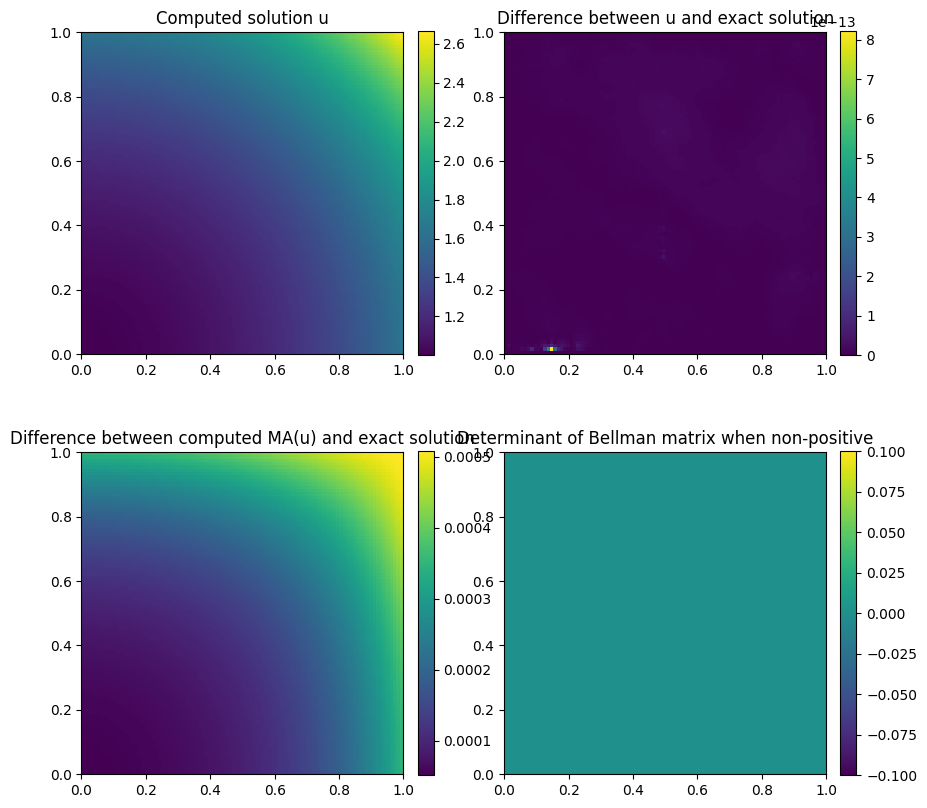

N =  100
Computed solution : Maximal error =  8.21e-13 Average l^2 error =  1.30e-16
Computed MA       : Maximal error =  5.08e-04 Average l^2 error =  2.32e-06  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


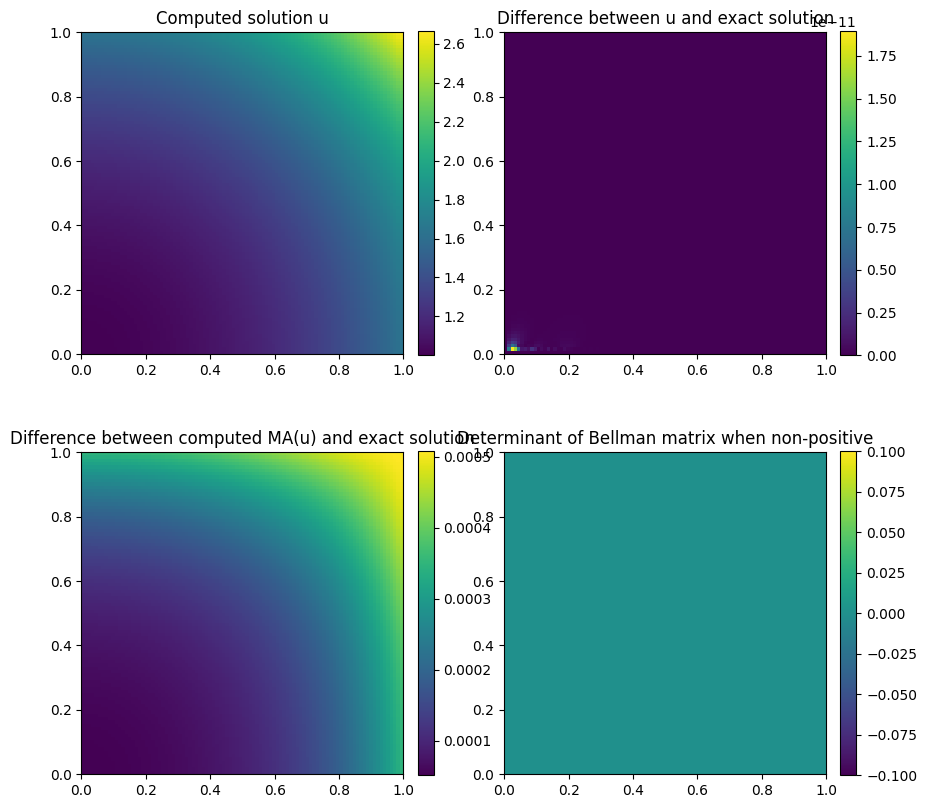

N =  100
Computed solution : Maximal error =  1.89e-11 Average l^2 error =  3.10e-15
Computed MA       : Maximal error =  5.08e-04 Average l^2 error =  2.32e-06  Two outermost layers excluded
Degeneracy count =  0 (0.0%)


In [15]:

B00 = 1 + np.zeros(shape)
B01 = np.zeros(shape)
B11 = 1 + np.zeros(shape)

for i in range(20):
    L = Coef(B00) * d2_dx2 + Coef(B01)*d2_dxdy + Coef(B01)*d2_dydx + Coef(B11)*d2_dy2

    pde = PDE(L, f, bc)
    u = pde.solve()
        
    u00 = d2_dx2(u)
    u01 = 0.5 * (d2_dxdy(u) + d2_dydx(u))
    u11 = d2_dy2(u)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            bellman_result=Bellman(u00[i][j], u01[i][j], u11[i][j])
            if bellman_result=="zeros":
                break
            B, singularity[i][j] = Bellman(u00[i][j], u01[i][j], u11[i][j])

            B00[i][j] = B[0][0]
            B01[i][j] = B[0][1]
            B11[i][j] = B[1][1]
    for k in range(N):
        r1=0
        r2=0
        c1=0
        c2=0
        #print("last","k",k,"j",j,"s",singularity[k][j],"c1",c1,"c2",c2,"r1",r1,"r2",r2)
        for j in range(N):
            if singularity[k][j]!=0:
                c1=search_points_c1(k,j)
                c2=search_points_c2(k,j)
                r1=search_points_r1(k,j)
                r2=search_points_r2(k,j)
                #print("k",k,"j",j,"s",singularity[k][j],"c1",c1,"c2",c2,"r1",r1,"r2",r2)
                B=eigen_interpolation(k,j,r1,r2,c1,c2)
                B00[k][j]=B[0][0]
                B01[k][j]=B[0][1]
                B11[k][j]=B[1][1]
                singularity[k][j]=0 #comment out for eigen_interpolation_2
            #print("k",k,"j",j,"s",singularity[k][j],"c1",c1,"c2",c2,"r1",r1,"r2",r2)


    fig, ax = plt.subplots(2, 2, figsize=(10,10))
    im = ax[0][0].imshow(np.flip(u[1:-1,1:-1].transpose(), 0), extent=[0,1,0,1])
    ax[0][0].set_title('Computed solution u')

    fig.colorbar(im, ax=ax[0][0], fraction=0.046, pad=0.04)

    delta = np.flip(np.transpose(abs(u-exact)), 0)
    
    im_delta = ax[0][1].imshow(delta[1:-1,1:-1], extent=[0,1,0,1])
    fig.colorbar(im_delta, ax=ax[0][1], fraction=0.046, pad=0.04)
    ax[0][1].set_title('Difference between u and exact solution')

    diff_MA = np.flip(np.transpose(abs(u00*u11-u01**2 - MA)), 0)
    im_diff_ma = ax[1][0].imshow(diff_MA[2:-2,2:-2], extent=[0,1,0,1])
    fig.colorbar(im_diff_ma, ax=ax[1][0], fraction=0.046, pad=0.04)
    ax[1][0].set_title('Difference between computed MA(u) and exact solution')
    
    im_sing = ax[1][1].imshow(np.flip(singularity[1:-1,1:-1].transpose(), 0), extent=[0,1,0,1])
    fig.colorbar(im_sing, ax=ax[1][1], fraction=0.046, pad=0.04)
    ax[1][1].set_title('Determinant of Bellman matrix when non-positive')

    plt.show()

    SingularityCount = np.count_nonzero(singularity[1:-1,1:-1])
    print("N = ", "{0:3d}".format(N))
    print("Computed solution : Maximal error = ", "{0:.2e}".format(np.max(np.abs(delta[1:-1,1:-1]))), "Average l^2 error = ", "{0:.2e}".format(LA.norm(delta[1:-1,1:-1]) / (N-2)**2))
    print("Computed MA       : Maximal error = ", "{0:.2e}".format(np.max(np.abs(diff_MA[2:-2,2:-2]))), "Average l^2 error = ", "{0:.2e}".format(LA.norm(diff_MA[2:-2,2:-2]) / (N-2)**2), " Two outermost layers excluded")
    print("Degeneracy count = ", SingularityCount, "({0:.1f}%)".format(100*SingularityCount/(N-2)**2))


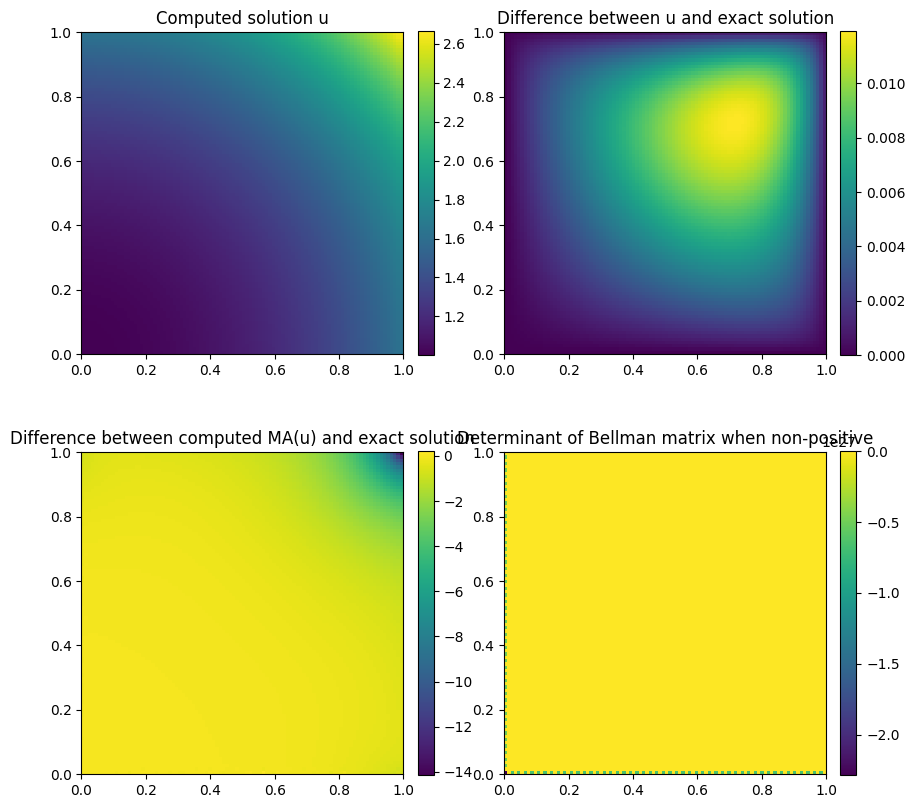

N =  100
Computed solution : Maximal error =  1.19e-02 Average l^2 error =  5.91e-05
Computed MA       : Maximal error =  1.42e+01 Average l^2 error =  1.05e-02  Two outermost layers excluded
Degeneracy count =  147 (1.5%)


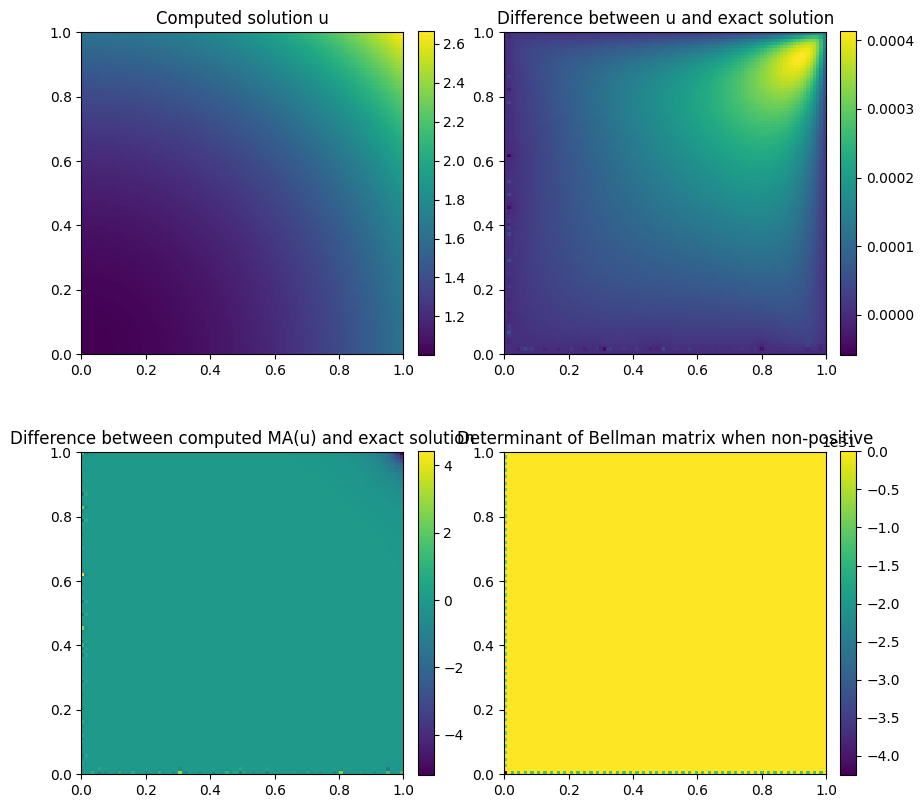

N =  100
Computed solution : Maximal error =  4.13e-04 Average l^2 error =  1.36e-06
Computed MA       : Maximal error =  5.20e+00 Average l^2 error =  1.81e-03  Two outermost layers excluded
Degeneracy count =  146 (1.5%)


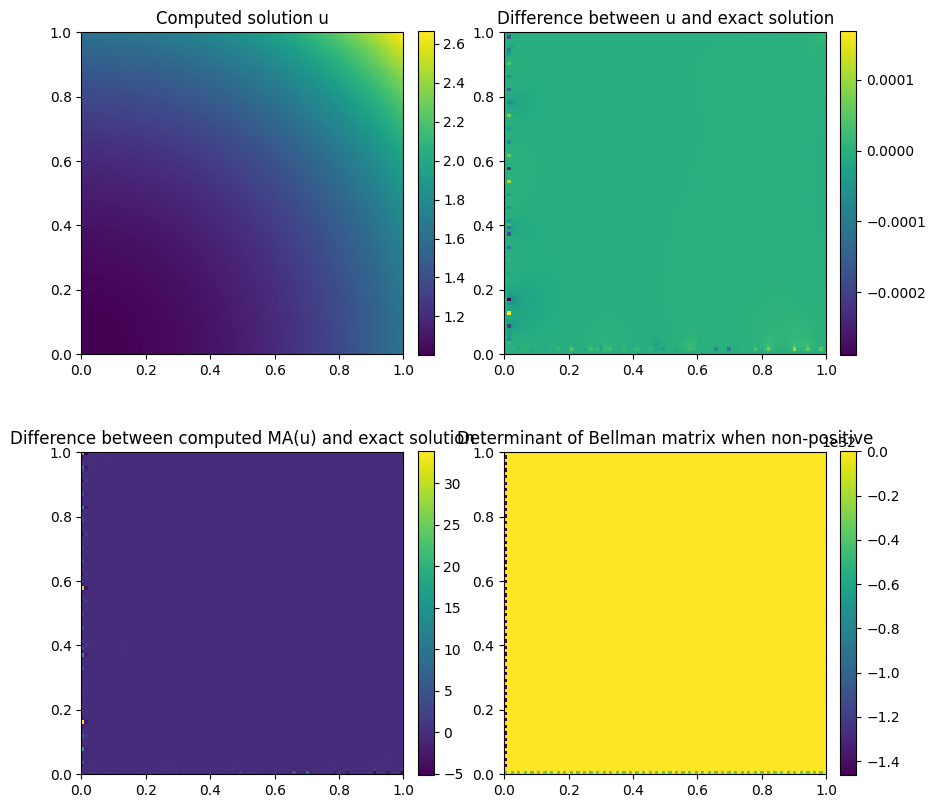

N =  100
Computed solution : Maximal error =  2.89e-04 Average l^2 error =  7.70e-08
Computed MA       : Maximal error =  3.39e+01 Average l^2 error =  6.75e-03  Two outermost layers excluded
Degeneracy count =  163 (1.7%)


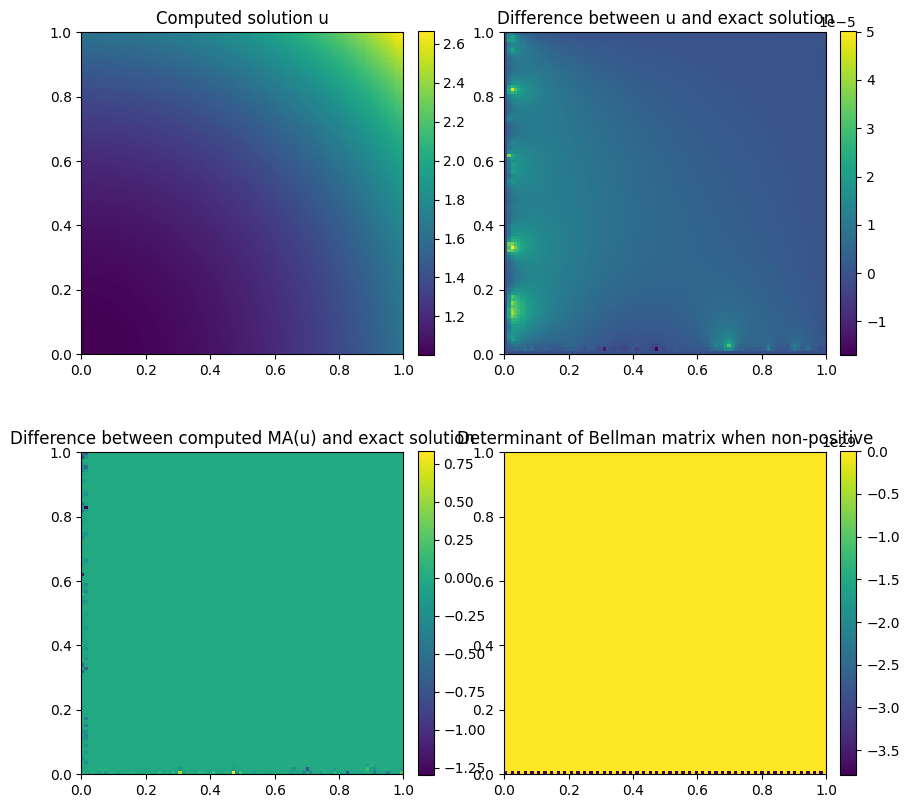

N =  100
Computed solution : Maximal error =  5.01e-05 Average l^2 error =  7.14e-08
Computed MA       : Maximal error =  1.30e+00 Average l^2 error =  3.42e-04  Two outermost layers excluded
Degeneracy count =  146 (1.5%)


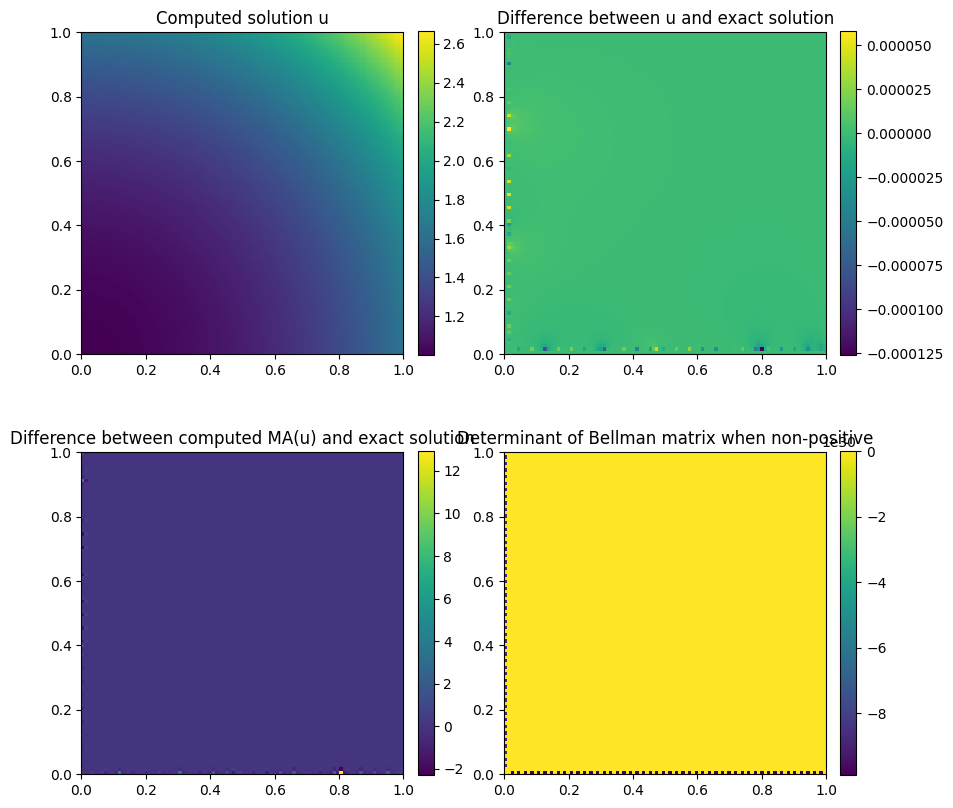

N =  100
Computed solution : Maximal error =  1.26e-04 Average l^2 error =  2.97e-08
Computed MA       : Maximal error =  1.29e+01 Average l^2 error =  1.86e-03  Two outermost layers excluded
Degeneracy count =  146 (1.5%)


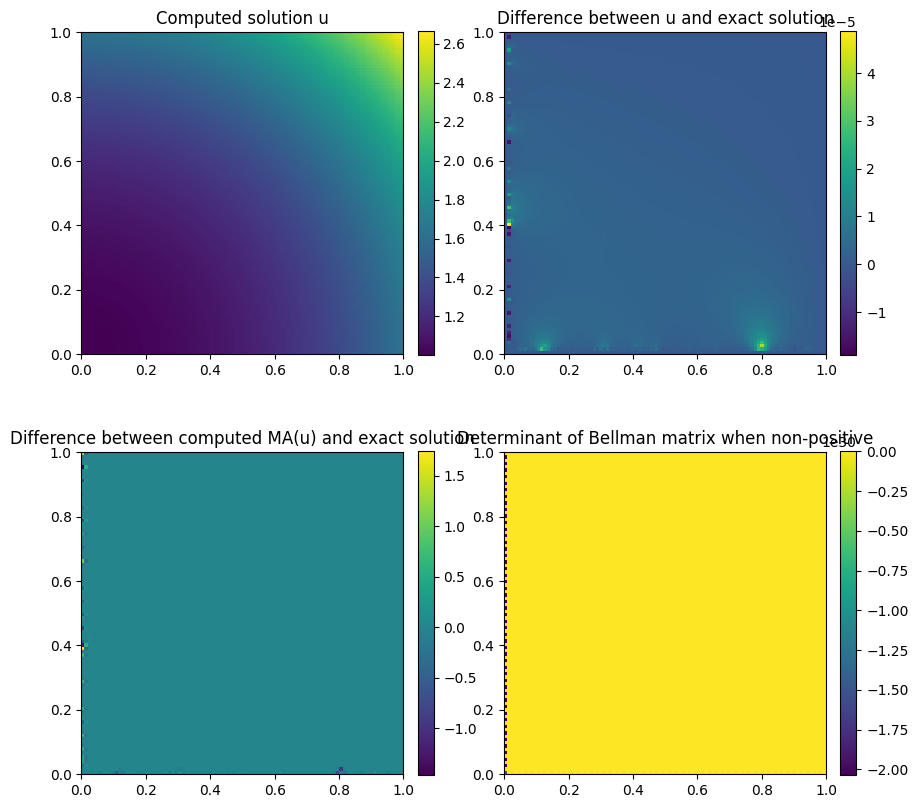

N =  100
Computed solution : Maximal error =  4.87e-05 Average l^2 error =  2.75e-08
Computed MA       : Maximal error =  1.74e+00 Average l^2 error =  4.80e-04  Two outermost layers excluded
Degeneracy count =  146 (1.5%)


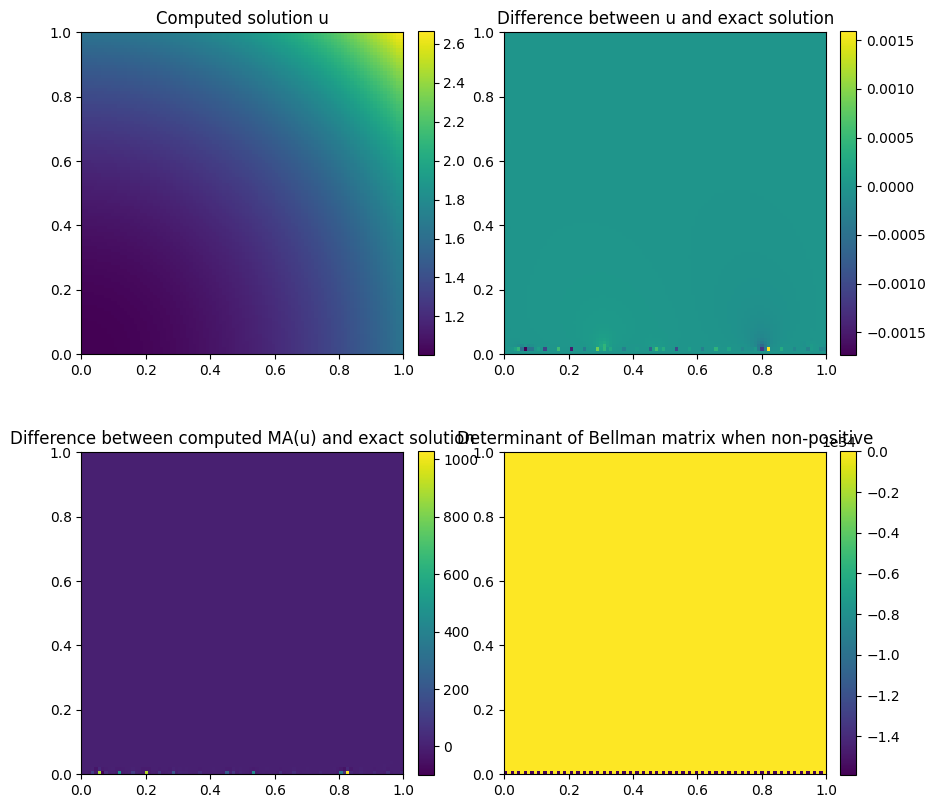

N =  100
Computed solution : Maximal error =  1.74e-03 Average l^2 error =  4.67e-07
Computed MA       : Maximal error =  1.03e+03 Average l^2 error =  1.91e-01  Two outermost layers excluded
Degeneracy count =  202 (2.1%)


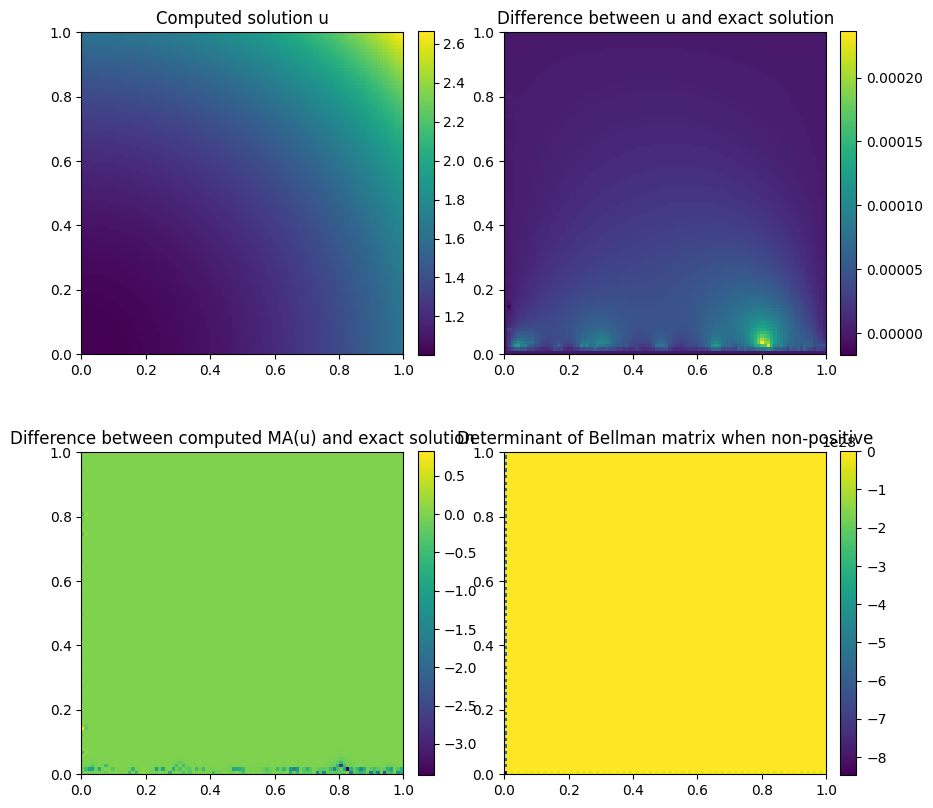

N =  100
Computed solution : Maximal error =  2.36e-04 Average l^2 error =  3.11e-07
Computed MA       : Maximal error =  3.41e+00 Average l^2 error =  8.76e-04  Two outermost layers excluded
Degeneracy count =  148 (1.5%)


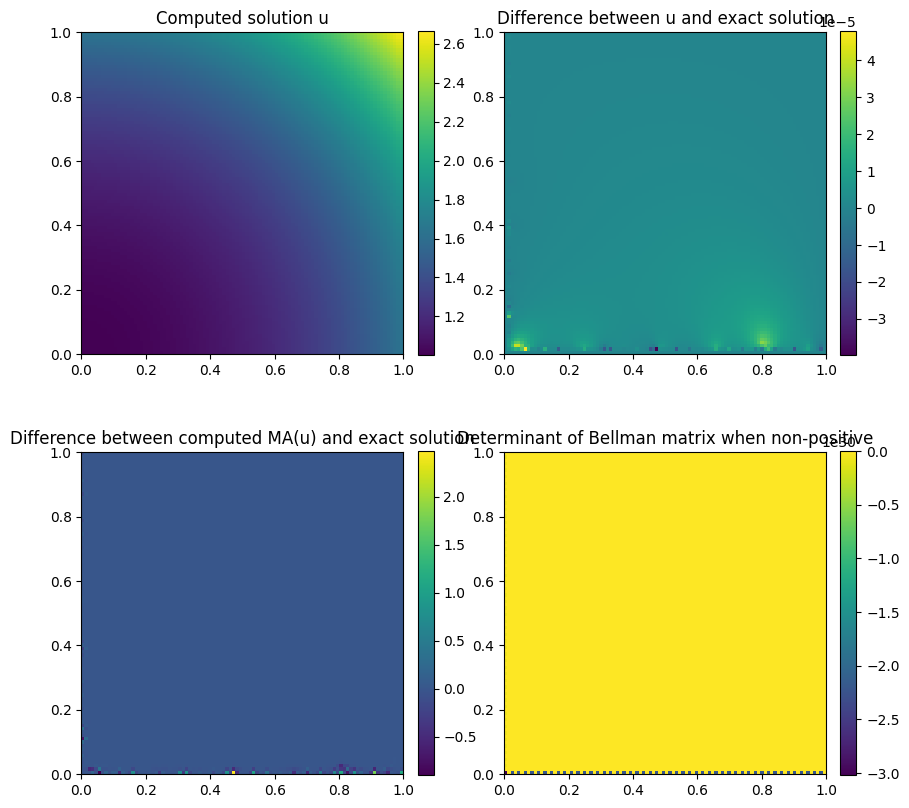

N =  100
Computed solution : Maximal error =  4.79e-05 Average l^2 error =  3.54e-08
Computed MA       : Maximal error =  2.48e+00 Average l^2 error =  5.15e-04  Two outermost layers excluded
Degeneracy count =  145 (1.5%)


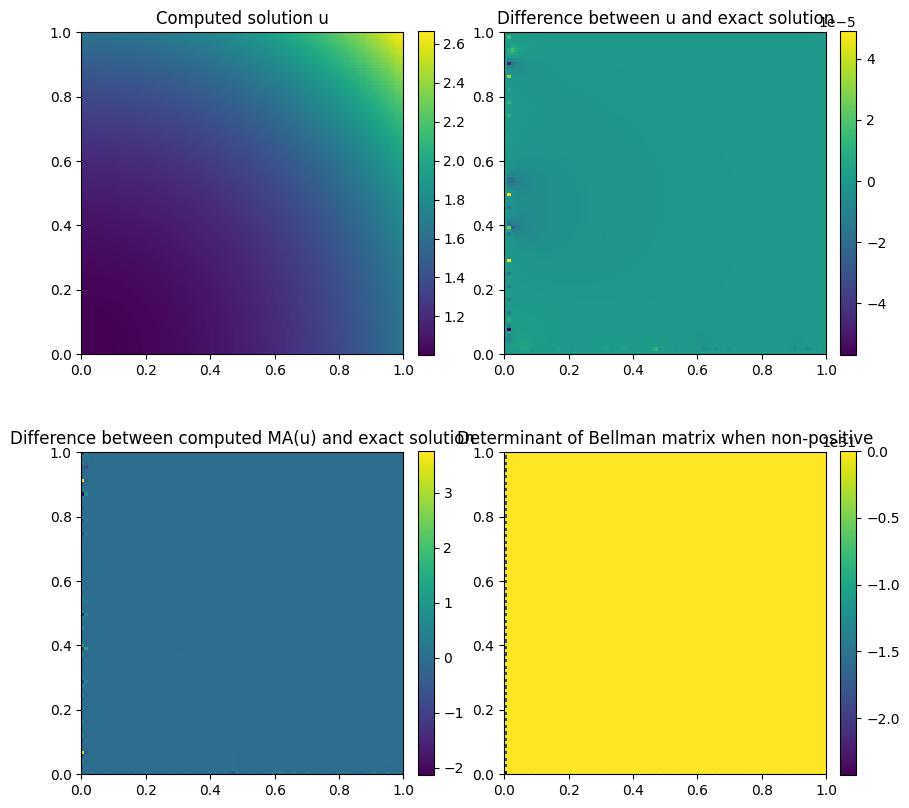

N =  100
Computed solution : Maximal error =  5.71e-05 Average l^2 error =  1.93e-08
Computed MA       : Maximal error =  3.75e+00 Average l^2 error =  7.57e-04  Two outermost layers excluded
Degeneracy count =  145 (1.5%)


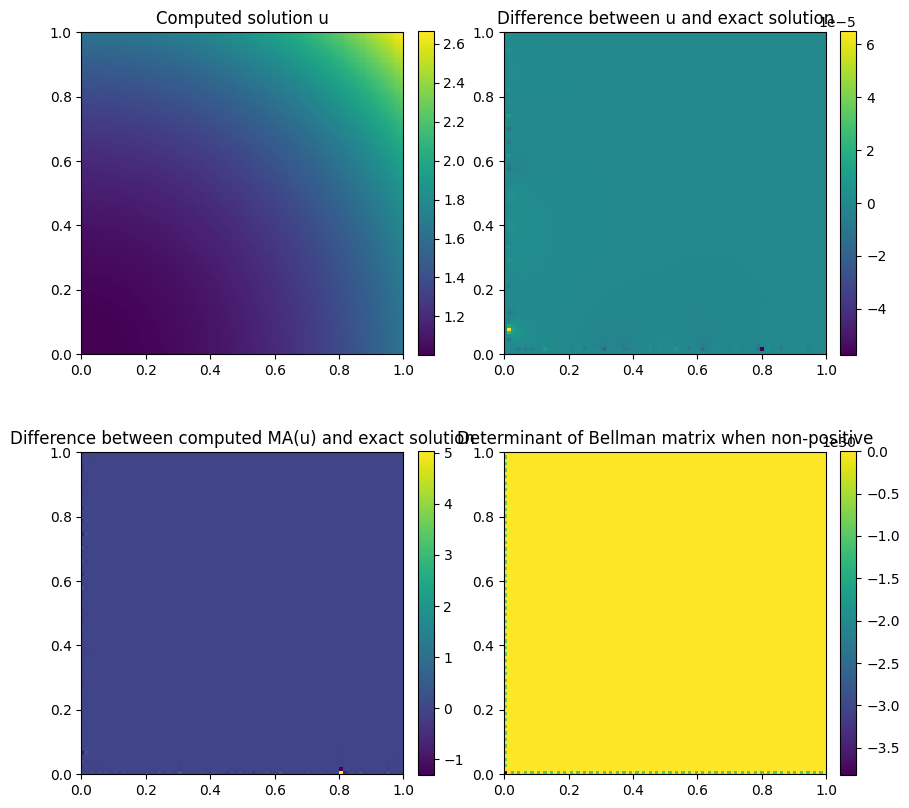

N =  100
Computed solution : Maximal error =  6.50e-05 Average l^2 error =  1.29e-08
Computed MA       : Maximal error =  5.03e+00 Average l^2 error =  6.15e-04  Two outermost layers excluded
Degeneracy count =  146 (1.5%)


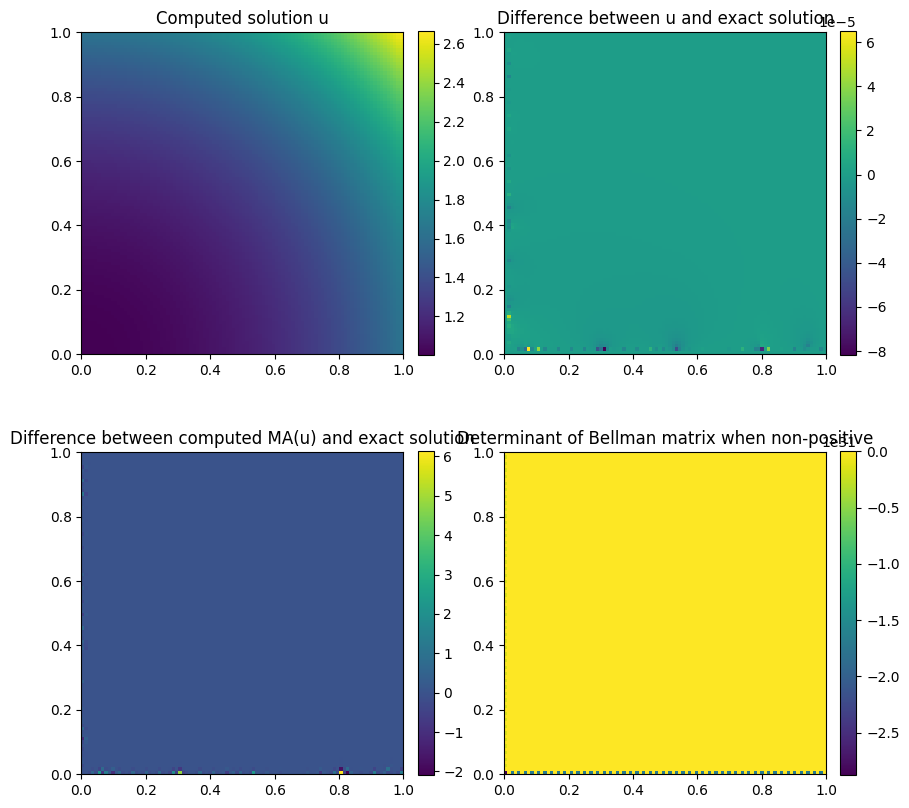

N =  100
Computed solution : Maximal error =  8.20e-05 Average l^2 error =  2.22e-08
Computed MA       : Maximal error =  6.13e+00 Average l^2 error =  1.08e-03  Two outermost layers excluded
Degeneracy count =  145 (1.5%)


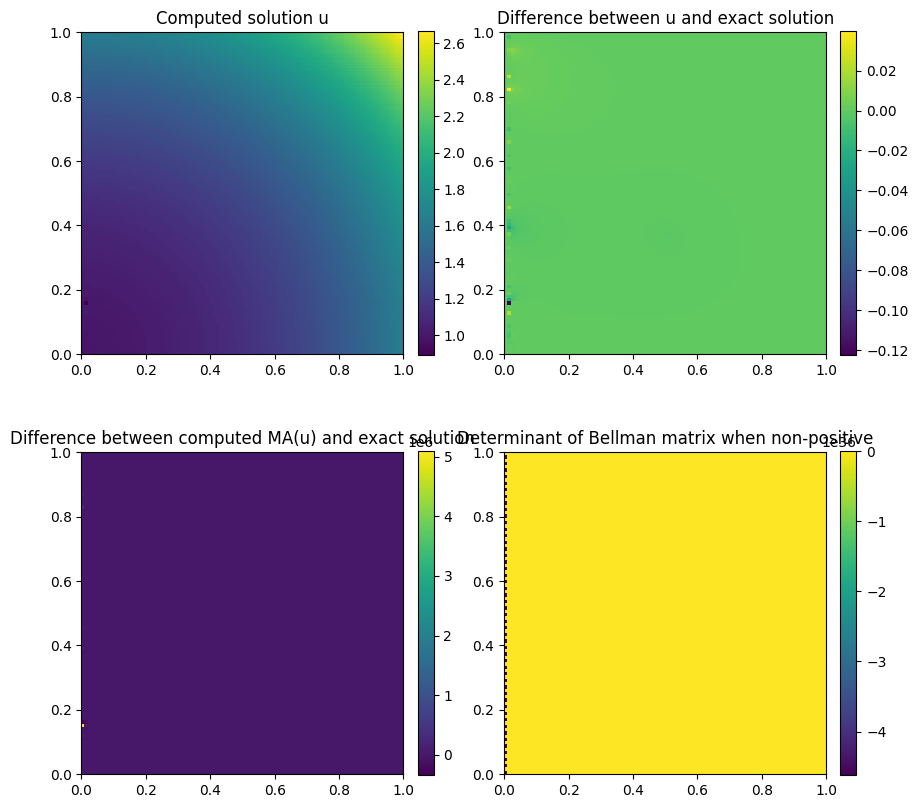

N =  100
Computed solution : Maximal error =  1.23e-01 Average l^2 error =  1.65e-05
Computed MA       : Maximal error =  5.09e+06 Average l^2 error =  5.35e+02  Two outermost layers excluded
Degeneracy count =  397 (4.1%)


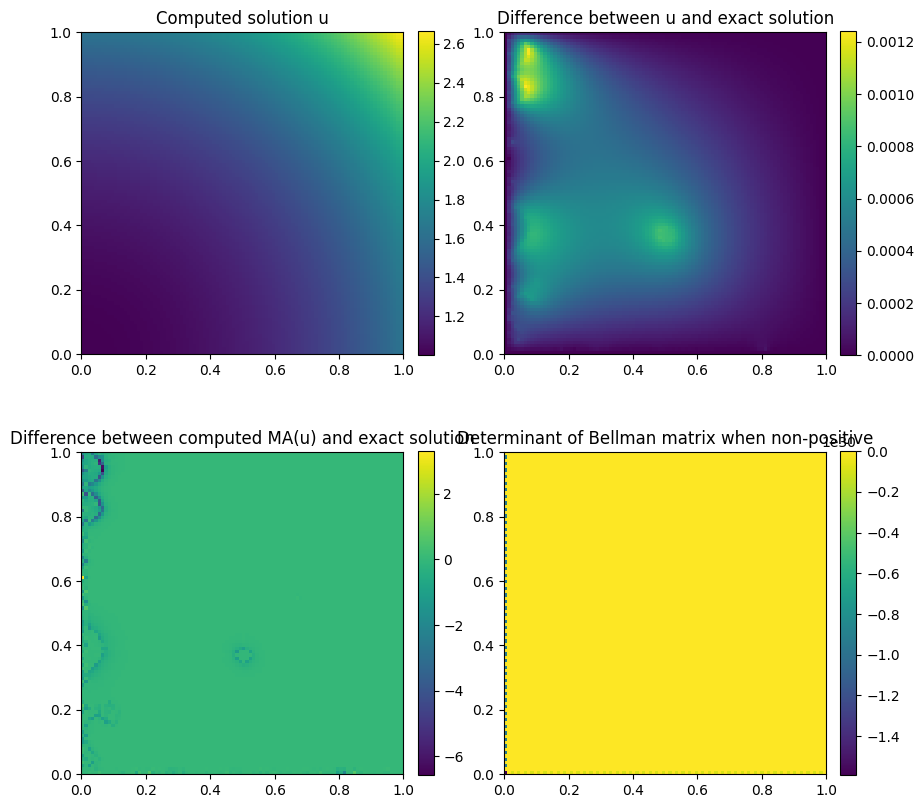

N =  100
Computed solution : Maximal error =  1.24e-03 Average l^2 error =  3.74e-06
Computed MA       : Maximal error =  6.58e+00 Average l^2 error =  2.56e-03  Two outermost layers excluded
Degeneracy count =  163 (1.7%)


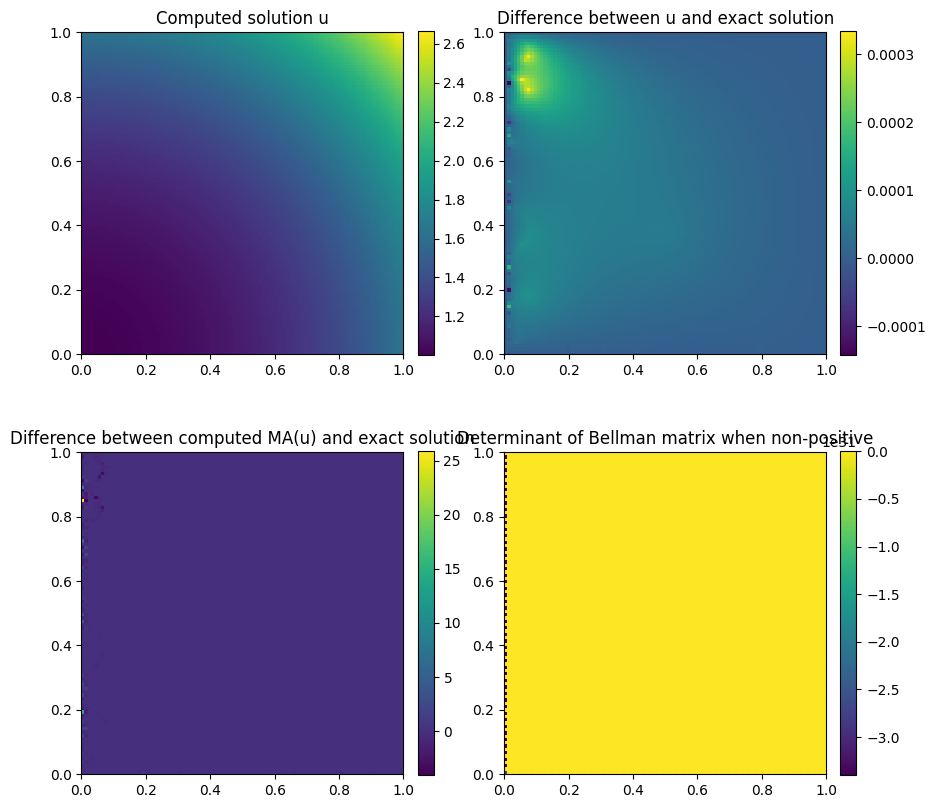

N =  100
Computed solution : Maximal error =  3.34e-04 Average l^2 error =  5.49e-07
Computed MA       : Maximal error =  2.59e+01 Average l^2 error =  3.73e-03  Two outermost layers excluded
Degeneracy count =  151 (1.6%)


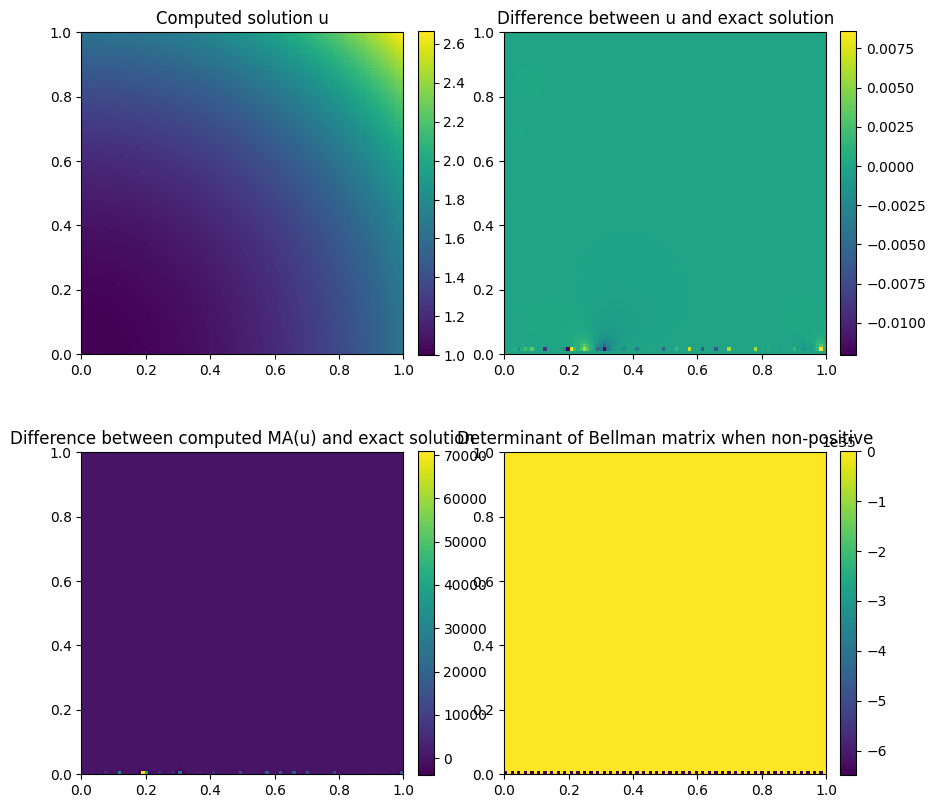

N =  100
Computed solution : Maximal error =  1.21e-02 Average l^2 error =  3.50e-06
Computed MA       : Maximal error =  7.09e+04 Average l^2 error =  1.05e+01  Two outermost layers excluded
Degeneracy count =  292 (3.0%)


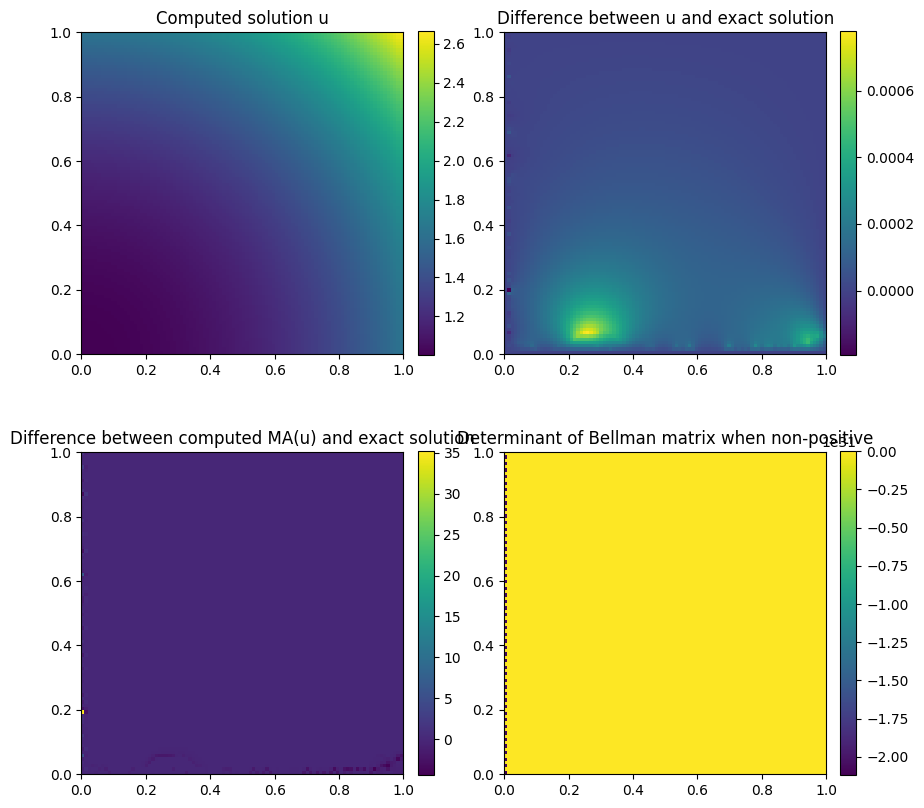

N =  100
Computed solution : Maximal error =  7.78e-04 Average l^2 error =  1.20e-06
Computed MA       : Maximal error =  3.52e+01 Average l^2 error =  4.20e-03  Two outermost layers excluded
Degeneracy count =  160 (1.7%)


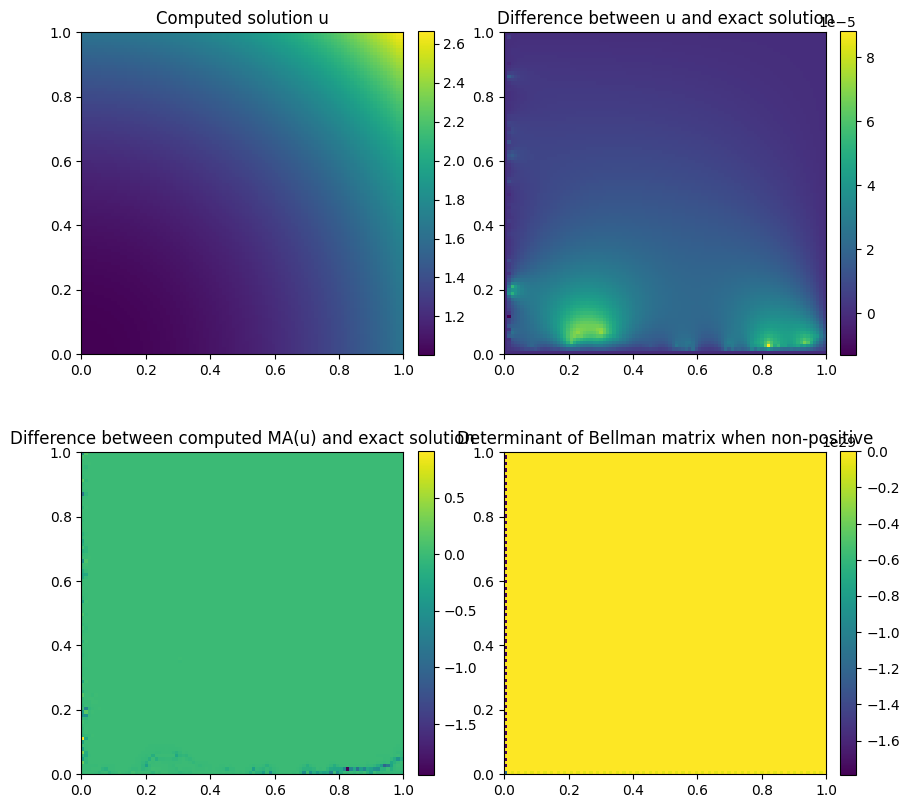

N =  100
Computed solution : Maximal error =  8.82e-05 Average l^2 error =  1.77e-07
Computed MA       : Maximal error =  1.95e+00 Average l^2 error =  4.19e-04  Two outermost layers excluded
Degeneracy count =  146 (1.5%)


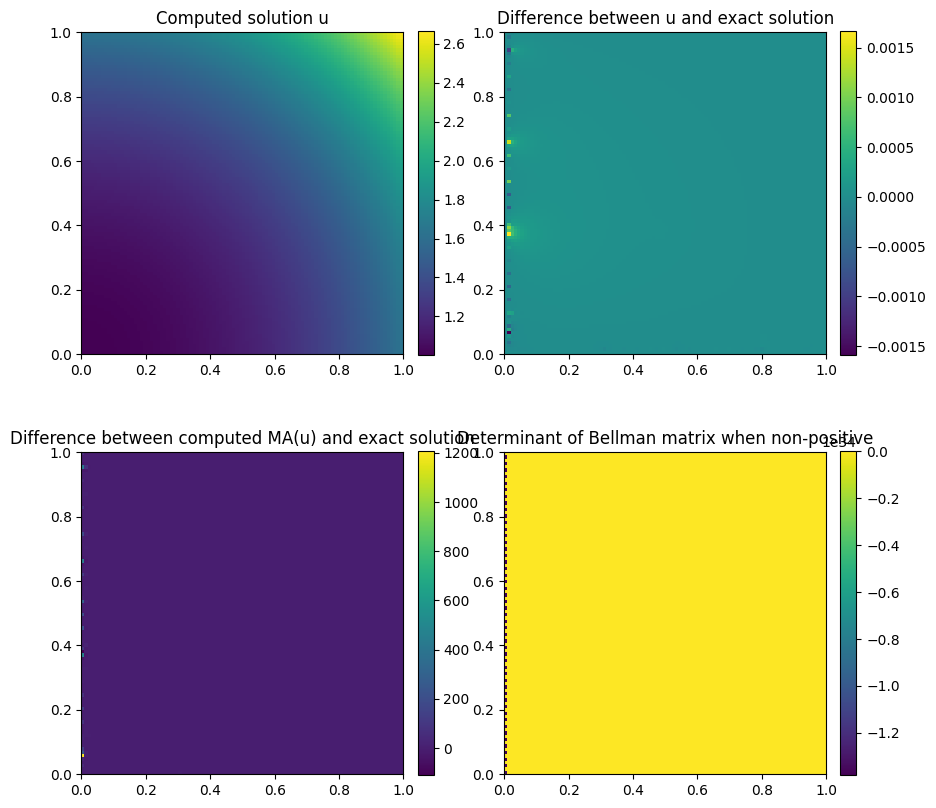

N =  100
Computed solution : Maximal error =  1.66e-03 Average l^2 error =  5.77e-07
Computed MA       : Maximal error =  1.21e+03 Average l^2 error =  1.62e-01  Two outermost layers excluded
Degeneracy count =  206 (2.1%)


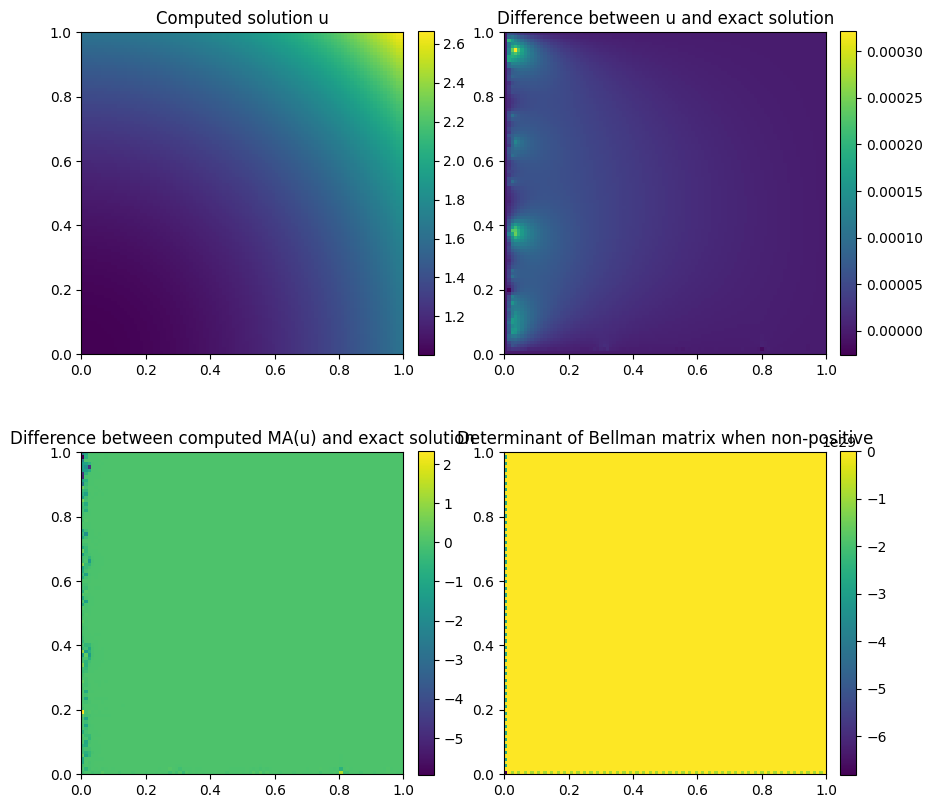

N =  100
Computed solution : Maximal error =  3.21e-04 Average l^2 error =  3.87e-07
Computed MA       : Maximal error =  5.95e+00 Average l^2 error =  1.44e-03  Two outermost layers excluded
Degeneracy count =  152 (1.6%)


In [16]:

B00 = 1 + np.zeros(shape)
B01 = np.zeros(shape)
B11 = 1 + np.zeros(shape)

for i in range(20):
    L = Coef(B00) * d2_dx2 + Coef(B01)*d2_dxdy + Coef(B01)*d2_dydx + Coef(B11)*d2_dy2

    pde = PDE(L, f, bc)
    u = pde.solve()
        
    u00 = d2_dx2(u)
    u01 = 0.5 * (d2_dxdy(u) + d2_dydx(u))
    u11 = d2_dy2(u)
    
    for i in range(shape[0]):
        for j in range(shape[1]):

            B, singularity[i][j] = Bellman(u00[i][j], u01[i][j], u11[i][j])
            
            if (i == 0 or i == shape[0] or j == 0 or j == shape[1]):
                singularity[i][j] = 0

            B00[i][j] = B[0][0]
            B01[i][j] = B[0][1]
            B11[i][j] = B[1][1]

    ## Idea for improvement:
    ## Loop over the grid again. At points where singularity[i][j] = 1, replace the identity matrix 
    ## by a suitably computed "linear interpolation" between points where B is computed in a reasonable
    ## way. For example, search in x- and y-directions for points where singularity == 0 and compute 
    ## B as a normalized (to get det=1) convex combination of the corresponding B's.
    fig, ax = plt.subplots(2, 2, figsize=(10,10))
    im = ax[0][0].imshow(np.flip(u[1:-1,1:-1].transpose(), 0), extent=[0,1,0,1])
    ax[0][0].set_title('Computed solution u')

    fig.colorbar(im, ax=ax[0][0], fraction=0.046, pad=0.04)

    delta = np.flip(np.transpose(u-exact), 0)
    
    im_delta = ax[0][1].imshow(delta[1:-1,1:-1], extent=[0,1,0,1])
    fig.colorbar(im_delta, ax=ax[0][1], fraction=0.046, pad=0.04)
    ax[0][1].set_title('Difference between u and exact solution')

    diff_MA = np.flip(np.transpose(u00*u11-u01**2 - MA), 0)
    im_diff_ma = ax[1][0].imshow(diff_MA[2:-2,2:-2], extent=[0,1,0,1])
    fig.colorbar(im_diff_ma, ax=ax[1][0], fraction=0.046, pad=0.04)
    ax[1][0].set_title('Difference between computed MA(u) and exact solution')
    
    im_sing = ax[1][1].imshow(np.flip(singularity[1:-1,1:-1].transpose(), 0), extent=[0,1,0,1])
    fig.colorbar(im_sing, ax=ax[1][1], fraction=0.046, pad=0.04)
    ax[1][1].set_title('Determinant of Bellman matrix when non-positive')

    plt.show()

    SingularityCount = np.count_nonzero(singularity[1:-1,1:-1])
    print("N = ", "{0:3d}".format(N))
    print("Computed solution : Maximal error = ", "{0:.2e}".format(np.max(np.abs(delta[1:-1,1:-1]))), "Average l^2 error = ", "{0:.2e}".format(LA.norm(delta[1:-1,1:-1]) / (N-2)**2))
    print("Computed MA       : Maximal error = ", "{0:.2e}".format(np.max(np.abs(diff_MA[2:-2,2:-2]))), "Average l^2 error = ", "{0:.2e}".format(LA.norm(diff_MA[2:-2,2:-2]) / (N-2)**2), " Two outermost layers excluded")
    print("Degeneracy count = ", SingularityCount, "({0:.1f}%)".format(100*SingularityCount/(N-2)**2))
